<br><br><br><br><br><br><br>

<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ</center>
<br>

<center>Федеральное государственное автономное образовательное учреждение высшего образования</center>
<center>«Национальный исследовательский Нижегородский государственный университет им. Н.И. Лобачевского» (ННГУ)</center>
<br>

<center>Институт информационных технологий, математики и механики</center>
<br>
<center>Кафедра алгебры, геометрии и дискретной математики</center>
<br>

<h2><center>Отчет по работе</center></h2>
<h1><center>«Использование эластичных графов для визуализации и анализа данных»</center></h1>

<br><br><br><br><br><br>

<div style="text-align: right">
    <div> <b>Выполнил:</b> </div>
    <div> студент группы 381803-1 </div>
    <div> Герасимов М. А. </div>
    <br>
    <div><b>Проверил:</b></div>
    <div>директор ИИТММ, заведующий кафедрой АГДМ</div>
    <div>Золотых. Н. Ю.</div>
</div>

<br><br><br><br><br><br><br><br><br><br><br><br>

<center>Нижний Новгород</center>
<center>2022</center>
<br>

# Введение

Данная работа - вторая часть совместной работы по визуализации данных с целью выделения в них различных кластеров и возможных путей развития сердечно-сосудистых заболеваний. В качестве наборов данных взяты две обработанные с помощью сегментирующей нейронной сети базы данных ЭКГ, содержащие более 20000 записей для различных пациентов (результат первой части работы). В этой части будут разобраны различные способы пост-обработки наборов данных для их подготовки к визуализации, и затем будет проведена сама визуализация с последующим анализом. Для визуализации будет использован модуль ElPiGraph, позволяющий строить эластичные графы.

# Постановка задачи

1. Подготовить полученную из первой части работы базу данных для визуализации,
2. Визуализировать данные с помощью ElPiGraph,
3. Проанализировать полученные результаты.

# Работа над программой

Для выполнения работы используются базы данных CSPC2018 и PTB-XL, предварительно обработанные сегментирующей нейронной сетью. После обработки базы представляют собой таблицы, в который каждой строке соответствуют пациент, а каждому столбцу - определенная характеристика (признак) пациента (возраст, рост, сердечный ритм и т.д.). Также в каждой базе данных есть столбец или несколько столбцов, указывающих на диагноз. В базе данных CSPC2018 24000 строк, а в базе PTB-XL - 21837 строк.



## 1. Обработка данных

Первый этап - обработка данных. Предварительно каждая из баз данных разбивается на 4: первая остается без изменений, во второй удаляются все здоровые пациенты, в третьей удаляются столбцы, отвечающие за диагнозы, а четвертая является комбинацией второй и третьей. Такой подход позволит отследить влияние здоровых пациентов и диагнозов на построение эластичного графа.

Импортируем необходимые модули:

In [1]:
from __future__ import division, print_function, unicode_literals

import sys
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import IPython as IPy
import sklearn as skl
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
import tarfile
import urllib
import pickle

import joblib

import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from importlib import reload

from VisualisationTests.clintraj_qi import *
from VisualisationTests.clintraj_optiscale import *
from VisualisationTests.clintraj_eltree import *
from VisualisationTests.clintraj_util import *
import scipy.stats

C:\Users\mikha\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\mikha\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\mikha\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\mikha\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [3]:
def save_obj(obj, name):
    os.makedirs("obj/New_dataset", exist_ok=True)
    with open('obj/New_dataset/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('obj/New_dataset/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### База данных на основе CSPC2018

In [4]:
cspc2018 = pd.read_csv('datasets/cspc2018_OHE.csv', sep=',')
cspc2018

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0          0  0.076632           NaN      0.279263    0.123100         NaN   
1          1  0.107158           NaN      0.298000    0.112200         NaN   
2          2  0.082800           NaN      0.284947    0.108200         NaN   
3          3  0.081500           NaN      0.314706    0.142556         NaN   
4          4  0.075053           NaN      0.268421    0.084762         NaN   
...      ...       ...           ...           ...         ...         ...   
23995  23995  0.104125           0.0      0.376000    0.153500    0.071875   
23996  23996  0.100500           0.0      0.413750    0.193625    0.080750   
23997  23997  0.094750           0.0      0.420625    0.190500    0.087500   
23998  23998  0.091500           0.0      0.416125    0.178625    0.093750   
23999  23999  0.086625           0.0      0.415625    0.177250    0.099625   

       Heart_rate_mean  sex  age        QRSA  ...  Unidentified  AF  I-AVB  \
0           171.184023    0   74 -596.758874  ...             0   0      0   
1           187.826087    0   74 -790.003412  ...             0   0      0   
2           186.244078    0   74 -230.210919  ...             0   1      0   
3           185.546875    0   74  685.091725  ...             0   1      0   
4           170.239596    0   74 -214.589496  ...             0   0      0   
...                ...  ...  ...         ...  ...           ...  ..    ...   
23995        75.942958    1   61   31.864414  ...             1   0      0   
23996        75.598488    1   61  -34.948739  ...             1   0      0   
23997        75.062552    1   61  -98.447443  ...             1   0      0   
23998        74.775673    1   61 -111.225219  ...             1   0      0   
23999        74.300338    1   61  -99.083990  ...             1   0      0   

       LBBB  Normal  PAC  PVC  RBBB  STD  STE  
0         0       0    0    0     1    0    0  
1         0       1    0    0     0    0    0  
2         0       0    0    0     0    0    0  
3         0       0    0    0     0    0    0  
4         0       0    0    1     0    0    0  
...     ...     ...  ...  ...   ...  ...  ...  
23995     0       0    0    0     0    0    0  
23996     0       0    0    0     0    0    0  
23997     0       0    0    0     0    0    0  
23998     0       0    0    0     0    0    0  
23999     0       0    0    0     0    0    0  

[24000 rows x 24 columns]

Каждая строка датасета соответствует записи о некотором пациенте. Столбцы датасета состоят из столбцов-признаков (характеристик пациентов) и столбцов-диагнозов. Данные были собраны исходя из датасета CSPC2018, который состоял из голых сигналов по 12 каналам для каждого из пациентов, а также из дополнительной информации о пациенте (пол, возраст и тд).

Описание столбцов-признаков:

**Qrst_dur, P_Q_duration, Q_T_duration, T_duration, P_duration** - средние продолжительности комплексов QRST, P-Q, Q-T, T, P
**Heart_rate_mean** - средний сердечный ритм пациента (в bpm)
**Sex** - пол пациента
**Age** - возраст пациента
**QRSA, Q_av, R_av, S_av** - ?
**Heart_rate_std** - дисперсия сердечного ритма

Описание столбцов-диагнозов:

**Unidentified** - unidentified diagnosis
**Normal** - Normal ECG
**AF** - Atrial fibrillation
**I-AVB** - First-degree atrioventricular block
**LBBB, RBBB** - Left и Right bundle branch block
**PAC, PVC** - Premature atrial/ventricular contraction
**STD, STE** - ST-segment depression/elevated

In [5]:
cspc2018_wo_index = cspc2018.drop('index', axis=1)
print(f"Количество дубликатов: {len(cspc2018_wo_index.loc[cspc2018_wo_index.duplicated(), :].index)}")

Количество дубликатов: 0


Оценим количество пустых клеток в столбцах.

In [6]:
for col in cspc2018:
    print(f'{col}: {cspc2018[col].isna().sum()} NaN vals')

index: 0 NaN vals
Qrst_dur: 8 NaN vals
P_Q_duration: 3103 NaN vals
Q_T_duration: 14 NaN vals
T_duration: 13 NaN vals
P_duration: 3082 NaN vals
Heart_rate_mean: 10 NaN vals
sex: 0 NaN vals
age: 0 NaN vals
QRSA: 0 NaN vals
Q_av: 8 NaN vals
R_av: 8 NaN vals
S_av: 8 NaN vals
Heart_rate_std: 10 NaN vals
Unidentified: 0 NaN vals
AF: 0 NaN vals
I-AVB: 0 NaN vals
LBBB: 0 NaN vals
Normal: 0 NaN vals
PAC: 0 NaN vals
PVC: 0 NaN vals
RBBB: 0 NaN vals
STD: 0 NaN vals
STE: 0 NaN vals


In [7]:
quantify_nans(cspc2018)

Missing values 6264 (1.134782608695652%)
Number of complete rows: 19325 (80.52083333333333%)


Проверим, есть ли в датасете пациенты с несколькими диагнозами или пациенты без диагнозов.

In [8]:
multi_ixs = cspc2018[(cspc2018['Unidentified'] +
                      cspc2018['AF'] +
                      cspc2018['I-AVB'] +
                      cspc2018['LBBB'] +
                      cspc2018['Normal'] +
                      cspc2018['PAC'] +
                      cspc2018['PVC'] +
                      cspc2018['RBBB'] +
                      cspc2018['STD'] +
                      cspc2018['STE'] > 1)].index

print(f"Количество пациентов с несколькими диагнозами: {len(multi_ixs)}")

Количество пациентов с несколькими диагнозами: 0


In [9]:
list_to_drop = []
for i in range(len(cspc2018)):
    if (cspc2018.at[i, 'Unidentified'] + cspc2018.at[i, 'AF'] + cspc2018.at[i, 'I-AVB'] + cspc2018.at[i, 'LBBB'] +
            cspc2018.at[i, 'Normal'] + cspc2018.at[i, 'PAC'] + cspc2018.at[i, 'PVC'] + cspc2018.at[i, 'RBBB'] +
            cspc2018.at[i, 'STD'] + cspc2018.at[i, 'STE'] == 0):
        list_to_drop.append(i)
print(f"Количетсво пациентов без диагноза: {len(list_to_drop)}")

Количетсво пациентов без диагноза: 0


Диагноз 'Unidentified' пока не представляет интереса. Удалим всех пациентов, имеющих этот диагноз

In [10]:
cspc2018 = cspc2018.drop(cspc2018[cspc2018.Unidentified == 1].index)
cspc2018 = cspc2018.drop('Unidentified', axis=1)

In [11]:
cspc2018

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0         0  0.076632           NaN      0.279263    0.123100         NaN   
1         1  0.107158           NaN      0.298000    0.112200         NaN   
2         2  0.082800           NaN      0.284947    0.108200         NaN   
3         3  0.081500           NaN      0.314706    0.142556         NaN   
4         4  0.075053           NaN      0.268421    0.084762         NaN   
...     ...       ...           ...           ...         ...         ...   
6872   6872  0.129455      0.156875      0.396636    0.172273    0.061900   
6873   6873  0.090091      0.160800      0.419273    0.156364    0.079909   
6874   6874  0.090909      0.186000      0.412909    0.178818    0.088632   
6875   6875  0.099545      0.197600      0.415091    0.179091    0.109125   
6876   6876  0.123818      0.186400      0.393455    0.188000    0.092600   

      Heart_rate_mean  sex  age        QRSA  ...  Heart_rate_std  AF  I-AVB  \
0          171.184023    0   74 -596.758874  ...        1.044164   0      0   
1          187.826087    0   74 -790.003412  ...        7.288161   0      0   
2          186.244078    0   74 -230.210919  ...       32.961007   1      0   
3          185.546875    0   74  685.091725  ...       33.344774   1      0   
4          170.239596    0   74 -214.589496  ...        1.757699   0      0   
...               ...  ...  ...         ...  ...             ...  ..    ...   
6872        87.221376    1   72  539.465959  ...        5.378318   0      1   
6873        82.503929    1   72  854.802387  ...        3.312691   0      0   
6874        82.595870    1   72  835.676295  ...        3.257122   0      0   
6875        83.643123    1   72  637.586024  ...        7.692503   1      0   
6876        70.307007    0   76  -95.918106  ...       10.651760   0      0   

      LBBB  Normal  PAC  PVC  RBBB  STD  STE  
0        0       0    0    0     1    0    0  
1        0       1    0    0     0    0    0  
2        0       0    0    0     0    0    0  
3        0       0    0    0     0    0    0  
4        0       0    0    1     0    0    0  
...    ...     ...  ...  ...   ...  ...  ...  
6872     0       0    0    0     0    0    0  
6873     0       0    0    0     0    1    0  
6874     1       0    0    0     0    0    0  
6875     0       0    0    0     0    0    0  
6876     0       0    0    1     0    0    0  

[6877 rows x 23 columns]

Узнаем примерное распределение диагнозов (0 - здоровые пациенты, >0 - пациенты с одним из классов аритмии в диагнозе).

In [12]:
cspc2018.loc[:, 'AF':].value_counts()

AF  I-AVB  LBBB  Normal  PAC  PVC  RBBB  STD  STE
0   0      0     0       0    0    1     0    0      1695
1   0      0     0       0    0    0     0    0      1098
0   0      0     1       0    0    0     0    0       918
                 0       0    0    0     1    0       826
    1      0     0       0    0    0     0    0       704
    0      0     0       0    1    0     0    0       653
                         1    0    0     0    0       574
           1     0       0    0    0     0    0       207
           0     0       0    0    0     0    1       202
dtype: int64

Попробуем определить выбросы в данных. Для этого используем алгоритм LocalOutlierFactor - нахождение коэффициента "удаленности" точки от её соседей. В качестве метрики расстояния между точками возьмем метрику Махалонобиса - это метрика на основе Евклидовой, учитывающая корреляции между столбцами. Так как в данных есть пропуски, заполним их медианами по признакам (далее при построении деревьев будет использоваться этот же подход).

In [13]:
from sklearn.neighbors import LocalOutlierFactor

cspc2018_no_nan = cspc2018.fillna(cspc2018.median())

loc_factor = LocalOutlierFactor(metric='mahalanobis', n_jobs=-1)

cspc_loc_pred = pd.Series(loc_factor.fit_predict(cspc2018_no_nan))
cspc_loc_pred.value_counts()

 1    6780
-1      97
dtype: int64

In [14]:
cspc_loc_pred[cspc_loc_pred == -1].index

Int64Index([   6,   58,  124,  127,  128,  129,  211,  212,  213,  214,  231,
             255,  257,  258,  461,  576,  580,  680,  689,  691,  731,  734,
             753,  795,  797,  798,  799,  802,  819,  822,  825,  901,  908,
             916, 1327, 1350, 1403, 1732, 1736, 2041, 2042, 2045, 2064, 2080,
            2087, 2104, 2188, 2563, 2652, 2653, 2682, 2716, 2785, 2788, 3187,
            3209, 3930, 4082, 4085, 4180, 4183, 4184, 4185, 4558, 4559, 4981,
            4984, 4986, 4987, 4988, 4991, 5133, 5173, 5174, 5175, 5176, 5177,
            5178, 5179, 5181, 5182, 5183, 5278, 5378, 5503, 5855, 5944, 6068,
            6203, 6339, 6547, 6603, 6606, 6609, 6611, 6618, 6858],
           dtype='int64')

Получаем, что 97 точек в CSPC2018 оказываются выбросами с точки зрения коэффициента LocalOutlierFactor. Есть два варианта действий - удалить их совсем или же как-то учесть их "аномальную" природу в дальнейшей работе. Попробуем пока не удалять выбросы.

Перемешаем строчки нашего датасета в случайном порядке.

In [15]:
cspc2018 = cspc2018.sample(frac=1).reset_index(drop=True)
cspc2018

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0      2480  0.094600      0.154000      0.389200    0.229000    0.085200   
1      3783  0.085867      0.111333      0.316400    0.129149    0.078000   
2      5230  0.091538      0.162000      0.314923    0.123692    0.092000   
3      6698  0.082800      0.207800      0.423778    0.182000    0.096400   
4      1360  0.093238      0.118286      0.412667    0.191091    0.078000   
...     ...       ...           ...           ...         ...         ...   
6872   2038  0.093000           NaN      0.355063    0.187636         NaN   
6873   6340  0.086516      0.125333      0.337862    0.152690    0.046500   
6874   2532  0.083833      0.147000      0.339636    0.169000    0.099167   
6875   5792  0.084800      0.131556      0.381000    0.171600    0.097778   
6876   2474  0.082000      0.145111      0.386000    0.194800    0.072889   

      Heart_rate_mean  sex  age        QRSA  ...  Heart_rate_std  AF  I-AVB  \
0           81.706764    1   72 -600.240654  ...       13.986104   0      1   
1          112.584758    1   62 -130.026882  ...       44.618254   0      0   
2          120.220404    0   86 -298.590445  ...        5.161792   0      0   
3           68.044355    0   68  850.520022  ...       61.227616   0      0   
4           72.041784    0   40 -229.949364  ...        7.299443   0      0   
...               ...  ...  ...         ...  ...             ...  ..    ...   
6872       112.454655    1   22  240.299490  ...       70.835775   0      0   
6873       115.466034    1   80   11.236485  ...       41.108694   0      0   
6874        78.106509    0   16 -301.149438  ...       10.793134   0      0   
6875        77.010839    1   72 -559.959831  ...        5.041188   0      1   
6876        80.285459    1   72   32.587179  ...       14.029730   0      0   

      LBBB  Normal  PAC  PVC  RBBB  STD  STE  
0        0       0    0    0     0    0    0  
1        0       0    0    1     0    0    0  
2        0       0    0    1     0    0    0  
3        0       1    0    0     0    0    0  
4        0       0    1    0     0    0    0  
...    ...     ...  ...  ...   ...  ...  ...  
6872     0       0    0    0     1    0    0  
6873     0       0    0    1     0    0    0  
6874     0       0    0    0     1    0    0  
6875     0       0    0    0     0    0    0  
6876     0       1    0    0     0    0    0  

[6877 rows x 23 columns]

Создадим 3 новых датасета: датасет без учета здоровых пациентов, датасет без учета диагнозов и датасет, комбинирующий предыдущие два.

In [16]:
cspc2018_diagnoses = ['AF', 'I-AVB', 'LBBB', 'Normal', 'PAC', 'PVC',
                      'RBBB', 'STD', 'STE']

cspc2018_unhealthy = cspc2018.drop(cspc2018[(cspc2018['Normal'] == 1)].index).reset_index(drop=True)
cspc2018_unhealthy = cspc2018_unhealthy.drop(['Normal'], axis=1)
cspc2018_raw = cspc2018.drop(cspc2018_diagnoses, axis=1)
cspc2018_raw_unhealthy = cspc2018.drop(cspc2018[(cspc2018['Normal'] == 1)].index).drop(cspc2018_diagnoses,
                                                                                       axis=1).reset_index(drop=True)

Датасет без учета здоровых пациентов:

In [17]:
cspc2018_unhealthy

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0      2480  0.094600      0.154000      0.389200    0.229000    0.085200   
1      3783  0.085867      0.111333      0.316400    0.129149    0.078000   
2      5230  0.091538      0.162000      0.314923    0.123692    0.092000   
3      1360  0.093238      0.118286      0.412667    0.191091    0.078000   
4       922  0.087263      0.132667      0.358526    0.174842    0.095444   
...     ...       ...           ...           ...         ...         ...   
5954   6298  0.073429      0.125702      0.344000    0.199846    0.084769   
5955   2038  0.093000           NaN      0.355063    0.187636         NaN   
5956   6340  0.086516      0.125333      0.337862    0.152690    0.046500   
5957   2532  0.083833      0.147000      0.339636    0.169000    0.099167   
5958   5792  0.084800      0.131556      0.381000    0.171600    0.097778   

      Heart_rate_mean  sex  age        QRSA  ...         S_av  Heart_rate_std  \
0           81.706764    1   72 -600.240654  ...  1171.317635       13.986104   
1          112.584758    1   62 -130.026882  ...  1287.837398       44.618254   
2          120.220404    0   86 -298.590445  ...  1251.539897        5.161792   
3           72.041784    0   40 -229.949364  ...  1333.650278        7.299443   
4           95.473833    1   50   66.984469  ...  1868.830508       16.233729   
...               ...  ...  ...         ...  ...          ...             ...   
5954       109.627547    0   47  664.118110  ...  1321.200676        1.668539   
5955       112.454655    1   22  240.299490  ...  1625.553232       70.835775   
5956       115.466034    1   80   11.236485  ...  7579.894333       41.108694   
5957        78.106509    0   16 -301.149438  ...  3497.261252       10.793134   
5958        77.010839    1   72 -559.959831  ...  1645.576320        5.041188   

      AF  I-AVB  LBBB  PAC  PVC  RBBB  STD  STE  
0      0      1     0    0    0     0    0    0  
1      0      0     0    0    1     0    0    0  
2      0      0     0    0    1     0    0    0  
3      0      0     0    1    0     0    0    0  
4      1      0     0    0    0     0    0    0  
...   ..    ...   ...  ...  ...   ...  ...  ...  
5954   0      0     0    1    0     0    0    0  
5955   0      0     0    0    0     1    0    0  
5956   0      0     0    0    1     0    0    0  
5957   0      0     0    0    0     1    0    0  
5958   0      1     0    0    0     0    0    0  

[5959 rows x 22 columns]

Датасет без учета диагнозов:

In [18]:
cspc2018_raw

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0      2480  0.094600      0.154000      0.389200    0.229000    0.085200   
1      3783  0.085867      0.111333      0.316400    0.129149    0.078000   
2      5230  0.091538      0.162000      0.314923    0.123692    0.092000   
3      6698  0.082800      0.207800      0.423778    0.182000    0.096400   
4      1360  0.093238      0.118286      0.412667    0.191091    0.078000   
...     ...       ...           ...           ...         ...         ...   
6872   2038  0.093000           NaN      0.355063    0.187636         NaN   
6873   6340  0.086516      0.125333      0.337862    0.152690    0.046500   
6874   2532  0.083833      0.147000      0.339636    0.169000    0.099167   
6875   5792  0.084800      0.131556      0.381000    0.171600    0.097778   
6876   2474  0.082000      0.145111      0.386000    0.194800    0.072889   

      Heart_rate_mean  sex  age        QRSA      Q_av         R_av  \
0           81.706764    1   72 -600.240654  5.272545  1176.590180   
1          112.584758    1   62 -130.026882  7.181572  1295.018970   
2          120.220404    0   86 -298.590445  4.680824  1256.220721   
3           68.044355    0   68  850.520022  4.284050  1268.048387   
4           72.041784    0   40 -229.949364  9.089981  1342.740260   
...               ...  ...  ...         ...       ...          ...   
6872       112.454655    1   22  240.299490  3.407795  1628.961027   
6873       115.466034    1   80   11.236485  3.544145  7583.438478   
6874        78.106509    0   16 -301.149438  3.963528  3501.224780   
6875        77.010839    1   72 -559.959831  5.216120  1650.792439   
6876        80.285459    1   72   32.587179  4.219432  1174.148472   

             S_av  Heart_rate_std  
0     1171.317635       13.986104  
1     1287.837398       44.618254  
2     1251.539897        5.161792  
3     1263.764337       61.227616  
4     1333.650278        7.299443  
...           ...             ...  
6872  1625.553232       70.835775  
6873  7579.894333       41.108694  
6874  3497.261252       10.793134  
6875  1645.576320        5.041188  
6876  1169.929039       14.029730  

[6877 rows x 14 columns]

Датасет без учета здоровых пациентов и диагнозов:

In [19]:
cspc2018_raw_unhealthy

index  Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0      2480  0.094600      0.154000      0.389200    0.229000    0.085200   
1      3783  0.085867      0.111333      0.316400    0.129149    0.078000   
2      5230  0.091538      0.162000      0.314923    0.123692    0.092000   
3      1360  0.093238      0.118286      0.412667    0.191091    0.078000   
4       922  0.087263      0.132667      0.358526    0.174842    0.095444   
...     ...       ...           ...           ...         ...         ...   
5954   6298  0.073429      0.125702      0.344000    0.199846    0.084769   
5955   2038  0.093000           NaN      0.355063    0.187636         NaN   
5956   6340  0.086516      0.125333      0.337862    0.152690    0.046500   
5957   2532  0.083833      0.147000      0.339636    0.169000    0.099167   
5958   5792  0.084800      0.131556      0.381000    0.171600    0.097778   

      Heart_rate_mean  sex  age        QRSA      Q_av         R_av  \
0           81.706764    1   72 -600.240654  5.272545  1176.590180   
1          112.584758    1   62 -130.026882  7.181572  1295.018970   
2          120.220404    0   86 -298.590445  4.680824  1256.220721   
3           72.041784    0   40 -229.949364  9.089981  1342.740260   
4           95.473833    1   50   66.984469  3.643220  1872.473729   
...               ...  ...  ...         ...       ...          ...   
5954       109.627547    0   47  664.118110  3.725000  1324.925676   
5955       112.454655    1   22  240.299490  3.407795  1628.961027   
5956       115.466034    1   80   11.236485  3.544145  7583.438478   
5957        78.106509    0   16 -301.149438  3.963528  3501.224780   
5958        77.010839    1   72 -559.959831  5.216120  1650.792439   

             S_av  Heart_rate_std  
0     1171.317635       13.986104  
1     1287.837398       44.618254  
2     1251.539897        5.161792  
3     1333.650278        7.299443  
4     1868.830508       16.233729  
...           ...             ...  
5954  1321.200676        1.668539  
5955  1625.553232       70.835775  
5956  7579.894333       41.108694  
5957  3497.261252       10.793134  
5958  1645.576320        5.041188  

[5959 rows x 14 columns]

### База данных на основе PTB-XL

In [20]:
ptb_xl = pd.read_csv('datasets/ptb-xl.csv', sep=',')
ptb_xl = ptb_xl.drop('Unnamed: 0', axis=1)
ptb_xl

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21832   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21833   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21834   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21835   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21836   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21832     92.419048      11.880983  108.567796    27.656141         59.759659   
21833     88.633333       2.576820  196.740741    14.319977         50.200000   
21834     90.791667       3.243583  157.833333    24.029279         43.933333   
21835     86.100000       3.770942  177.083333    11.556095         84.820106   
21836     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               7.076908        142.796296          13.337037     1   0     0   
1               8.469103        104.809524          21.079054     1   0     0   
2               9.128249        146.740741          22.119764     1   0     0   
3               8.447915         78.383333          14.863938     1   0     0   
4               8.145649        110.259259          21.850785     1   0     0   
...                  ...               ...                ...   ...  ..   ...   
21832          10.016868        103.385648          24.841330     0   0     1   
21833           5.332917        110.592593          11.342770     1   0     0   
21834           7.617332        169.023810          29.124644     0   0     1   
21835          10.226346        107.100000          10.474413     1   0     0   
21836           9.264125        107.479167          12.467667     1   0     0   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...    ..  ...  
21832   0    0  
21833   0    0  
21834   0    0  
21835   0    0  
21836   0    0  

[21837 rows x 20 columns]

Каждая строка датасета соответствует записи о некотором пациенте. Столбцы датасета состоят из столбцов-признаков (характеристик пациентов) и столбцов-диагнозов. Данные были собраны исходя из датасета PTB-XL, который состоял из голых сигналов для каждого из пациентов, а также из дополнительной информации о пациенте (пол, возраст и тд).

Описание столбцов-признаков:

**SEX, AGE, HEIGHT, WEIGHT** - пол, возраст, рост и вес пациента
**ALL_C_P_AV, ALL_C_QRS_AV, ALL_C_T_AV, ALL_C_PR_SEGM_AV, ALL_C_ST_SEGM_AV** - средние продолжительности комплексов P, QRS, T, P-R, S-T (ALL_C - усреднение по всем каналам)
**ALL_C_P_DEV, ALL_C_QRS_DEV, ALL_C_T_DEV, ALL_C_PR_SEGM_DEV, ALL_C_ST_SEGM_DEV** - дисперсия продолжительности комплексов P, QRS, T, P-R, S-T (ALL_C - по всем каналам)

Описание столбцов-диагнозов:

**NORM** - Normal ECG
**MI** - Myocardial Infarction
**STTC** - ST/T Change
**CD** - Conduction Disturbance
**HYP** - Hypertrophy

Для поиска дубликатов нам необходимо избавиться от столбца 'ecg_id' (номер записи в таблице)

In [21]:
ptb_xl_wo_ecg = ptb_xl.drop('ecg_id', axis=1)
print(f"Количество дубликатов: {len(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index)}")
print(f"Индексы дубликатов: {ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index}")

Количество дубликатов: 24
Индексы дубликатов: Int64Index([  137,   143,   456,   459,   462,  2506,  3796,  3801,  7779,
             7780,  7783,  9822, 11812, 11814, 11816, 13791, 13793, 13795,
            13797, 13799, 13801, 15740, 15741, 18150],
           dtype='int64')


Удалим дубликаты

In [22]:
ptb_xl = ptb_xl.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(drop=True)
ptb_xl

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21808   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21809   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21810   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21811   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21812   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21808     92.419048      11.880983  108.567796    27.656141         59.759659   
21809     88.633333       2.576820  196.740741    14.319977         50.200000   
21810     90.791667       3.243583  157.833333    24.029279         43.933333   
21811     86.100000       3.770942  177.083333    11.556095         84.820106   
21812     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               7.076908        142.796296          13.337037     1   0     0   
1               8.469103        104.809524          21.079054     1   0     0   
2               9.128249        146.740741          22.119764     1   0     0   
3               8.447915         78.383333          14.863938     1   0     0   
4               8.145649        110.259259          21.850785     1   0     0   
...                  ...               ...                ...   ...  ..   ...   
21808          10.016868        103.385648          24.841330     0   0     1   
21809           5.332917        110.592593          11.342770     1   0     0   
21810           7.617332        169.023810          29.124644     0   0     1   
21811          10.226346        107.100000          10.474413     1   0     0   
21812           9.264125        107.479167          12.467667     1   0     0   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...    ..  ...  
21808   0    0  
21809   0    0  
21810   0    0  
21811   0    0  
21812   0    0  

[21813 rows x 20 columns]

Оценим количество пустых клеток в столбцах.

In [23]:
for col in ptb_xl:
    print(f'{col}: {ptb_xl[col].isna().sum()} NaN vals')

ecg_id: 0 NaN vals
SEX: 0 NaN vals
AGE: 89 NaN vals
HEIGHT: 14836 NaN vals
WEIGHT: 12390 NaN vals
ALL_C_P_AV: 0 NaN vals
ALL_C_P_DEV: 0 NaN vals
ALL_C_QRS_AV: 0 NaN vals
ALL_C_QRS_DEV: 0 NaN vals
ALL_C_T_AV: 0 NaN vals
ALL_C_T_DEV: 0 NaN vals
ALL_C_PR_SEGM_AV: 0 NaN vals
ALL_C_PR_SEGM_DEV: 0 NaN vals
ALL_C_ST_SEGM_AV: 0 NaN vals
ALL_C_ST_SEGM_DEV: 0 NaN vals
NORM: 0 NaN vals
MI: 0 NaN vals
STTC: 0 NaN vals
CD: 0 NaN vals
HYP: 0 NaN vals


In [24]:
quantify_nans(ptb_xl)

Missing values 27315 (6.590710030474344%)
Number of complete rows: 6674 (30.59643331958007%)


В датасете присутствуют пациенты без диагноза. Найдем их количество.

In [25]:
list_to_drop = []
for i in range(len(ptb_xl)):
    if (ptb_xl.at[i, 'NORM'] + ptb_xl.at[i, 'MI'] + ptb_xl.at[i, 'STTC'] + ptb_xl.at[i, 'CD'] + ptb_xl.at[
        i, 'HYP'] == 0):
        list_to_drop.append(i)
print(f"Количетсво пациентов без диагноза: {len(list_to_drop)}")

Количетсво пациентов без диагноза: 406


Относительно размера всего датасета количество пациентов без диагноза не столь велико. Для задачи они не представляют особого интереса, поэтому их можно удалить.

In [26]:
ptb_xl = ptb_xl.drop(ptb_xl.index[list_to_drop])
ptb_xl = ptb_xl.reset_index(drop=True)
ptb_xl

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21402   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21403   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21404   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21405   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21406   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21402     92.419048      11.880983  108.567796    27.656141         59.759659   
21403     88.633333       2.576820  196.740741    14.319977         50.200000   
21404     90.791667       3.243583  157.833333    24.029279         43.933333   
21405     86.100000       3.770942  177.083333    11.556095         84.820106   
21406     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               7.076908        142.796296          13.337037     1   0     0   
1               8.469103        104.809524          21.079054     1   0     0   
2               9.128249        146.740741          22.119764     1   0     0   
3               8.447915         78.383333          14.863938     1   0     0   
4               8.145649        110.259259          21.850785     1   0     0   
...                  ...               ...                ...   ...  ..   ...   
21402          10.016868        103.385648          24.841330     0   0     1   
21403           5.332917        110.592593          11.342770     1   0     0   
21404           7.617332        169.023810          29.124644     0   0     1   
21405          10.226346        107.100000          10.474413     1   0     0   
21406           9.264125        107.479167          12.467667     1   0     0   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
...    ..  ...  
21402   0    0  
21403   0    0  
21404   0    0  
21405   0    0  
21406   0    0  

[21407 rows x 20 columns]

В датасете присутствуют пациенты с несколькими диагнозами одновременно. Будем считать сочетания нескольких диагнозов за отдельные диагнозы. Посмотрим, какие варианты сочетаний у нас есть.

In [27]:
ptb_xl.loc[:, 'NORM':].value_counts().sort_index()

NORM  MI  STTC  CD  HYP
0     0   0     0   1       535
                1   0      1708
                    1       300
          1     0   0      2405
                    1       782
                1   0       472
                    1       211
      1   0     0   0      2535
                    1       183
                1   0      1300
                    1       117
          1     0   0       601
                    1       361
                1   0       223
                    1       157
1     0   0     0   0      9072
                    1         2
                1   0       407
                    1         2
          1     0   0        28
                1   0         5
      1   0     1   1         1
dtype: int64

В дальнейшем будем выделять следующие диагнозы:

<ol>
    <li>NORM</li>
    <li>MI</li>
    <li>STTC</li>
    <li>CD</li>
    <li>HYP</li>
    <li>MULTIPLE NORM - NORM + еще какой-то (какие-то) диагнозы</li>
    <li>PAIRED - парные диагнозы, ни один из которых не NORM</li>
    <li>MULTIPLE - множественные диагнозы, ни один из которых не NORM</li>
</ol>

Поищем выбросы.

In [28]:
ptb_xl_no_nan = ptb_xl.fillna(ptb_xl.median())

ptb_loc_pred = pd.Series(loc_factor.fit_predict(ptb_xl_no_nan))
ptb_loc_pred.value_counts()

 1    21099
-1      308
dtype: int64

In [29]:
ptb_loc_pred[ptb_loc_pred == -1].index

Int64Index([   57,   287,   306,   320,   355,   407,   461,   523,   533,
              557,
            ...
            20566, 20698, 20831, 20837, 20952, 21068, 21075, 21148, 21180,
            21264],
           dtype='int64', length=308)

Как и в случае с CSPC2018, создадим 3 новых датасета: датасет без учета здоровых пациентов, датасет без учета диагнозов и датасет, комбинирующий предыдущие два.

In [30]:
ptb_xl_diagnoses = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

ptb_xl_unhealthy = ptb_xl.drop(ptb_xl[(ptb_xl['NORM'] == 1) & (
        ptb_xl['MI'] + ptb_xl['STTC'] + ptb_xl['CD'] + ptb_xl['HYP'] == 0)].index).reset_index(drop=True)

ptb_xl_raw = ptb_xl.drop(ptb_xl_diagnoses, axis=1)
ptb_xl_wo_ecg = ptb_xl_raw.drop('ecg_id', axis=1)
ptb_xl_raw = ptb_xl_raw.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(drop=True)

ptb_xl_raw_unhealthy = ptb_xl_unhealthy.drop(ptb_xl_diagnoses, axis=1)
ptb_xl_wo_ecg = ptb_xl_raw_unhealthy.drop('ecg_id', axis=1)
ptb_xl_raw_unhealthy = ptb_xl_raw_unhealthy.drop(ptb_xl_wo_ecg.loc[ptb_xl_wo_ecg.duplicated(), :].index).reset_index(
    drop=True)

Датасет без учета здоровых пациентов:

In [31]:
ptb_xl_unhealthy

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           8    0  48.0     NaN    95.0  100.316667    12.131639   
1          22    1  17.0     NaN    53.0   88.981818     8.289819   
2          26    0  56.0     NaN     NaN   90.082492    15.961563   
3          28    0  56.0     NaN     NaN   83.306870    18.644523   
4          30    0  25.0     NaN    83.0  104.335648     8.618019   
...       ...  ...   ...     ...     ...         ...          ...   
12330   21828    1  79.0     NaN     NaN   64.097222    15.379986   
12331   21829    1  69.0     NaN     NaN   91.623148     8.659738   
12332   21832    0  63.0     NaN     NaN   32.339744     9.965069   
12333   21833    1  67.0     NaN     NaN   83.363930    14.132517   
12334   21835    1  59.0     NaN     NaN   89.650000    10.266897   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         85.550000       2.744085  178.900000    12.340719         76.300000   
1         85.393939       1.674637  164.712121    10.860498         50.475000   
2         97.666667       3.079953  152.022436    24.195624         80.789941   
3         90.172619       5.383836  124.888889    23.532573         69.916925   
4        112.518519       1.730862  212.740741    16.050332         66.331019   
...             ...            ...         ...          ...               ...   
12330    110.725758      16.007926  184.752525    30.887792         78.791667   
12331     89.183333       3.279736  169.148148    16.382265         46.106019   
12332    126.141026      13.074510  150.791667    18.174629         29.033476   
12333     92.419048      11.880983  108.567796    27.656141         59.759659   
12334     90.791667       3.243583  157.833333    24.029279         43.933333   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  NORM  MI  STTC  \
0               8.329466         93.866667          11.193748     0   1     0   
1               7.425126        112.772727           7.997589     0   0     1   
2              13.144295        101.794192          19.250009     0   0     1   
3              15.098691        131.702020          21.606788     0   0     1   
4               8.658260         84.925926           9.846977     0   0     0   
...                  ...               ...                ...   ...  ..   ...   
12330          18.590308        119.276094          22.078023     0   1     1   
12331           6.930727        120.814815          16.427669     1   0     0   
12332           3.770659        130.333333          15.713730     0   0     0   
12333          10.016868        103.385648          24.841330     0   0     1   
12334           7.617332        169.023810          29.124644     0   0     1   

       CD  HYP  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    1  
...    ..  ...  
12330   0    0  
12331   1    0  
12332   1    0  
12333   0    0  
12334   0    0  

[12335 rows x 20 columns]

Датасет без учета диагнозов:

In [32]:
ptb_xl_raw

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           1    1  56.0     NaN    63.0   88.854167    10.836725   
1           2    0  19.0     NaN    70.0   87.304365    12.881166   
2           3    1  37.0     NaN    69.0   82.310648    13.188344   
3           4    0  24.0     NaN    82.0   88.672703    12.592751   
4           5    1  19.0     NaN    70.0   92.718519    10.080940   
...       ...  ...   ...     ...     ...         ...          ...   
21392   21833    1  67.0     NaN     NaN   83.363930    14.132517   
21393   21834    0  93.0     NaN     NaN  100.100000     7.918754   
21394   21835    1  59.0     NaN     NaN   89.650000    10.266897   
21395   21836    1  64.0     NaN     NaN   98.320106    10.089180   
21396   21837    0  68.0     NaN     NaN   84.539286    14.477452   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         83.796296       2.678984  163.201852    16.356583         45.900926   
1         84.380952       2.950844  209.904762    21.595540         62.701984   
2         81.148148       4.022570  183.480808    24.391306         52.007407   
3         97.016667       2.889637  179.616667    19.635597         48.495370   
4         86.388889       2.561185  183.248148    19.222976         49.655556   
...             ...            ...         ...          ...               ...   
21392     92.419048      11.880983  108.567796    27.656141         59.759659   
21393     88.633333       2.576820  196.740741    14.319977         50.200000   
21394     90.791667       3.243583  157.833333    24.029279         43.933333   
21395     86.100000       3.770942  177.083333    11.556095         84.820106   
21396     81.333333       2.371708  199.509259    16.276656         74.144048   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  
0               7.076908        142.796296          13.337037  
1               8.469103        104.809524          21.079054  
2               9.128249        146.740741          22.119764  
3               8.447915         78.383333          14.863938  
4               8.145649        110.259259          21.850785  
...                  ...               ...                ...  
21392          10.016868        103.385648          24.841330  
21393           5.332917        110.592593          11.342770  
21394           7.617332        169.023810          29.124644  
21395          10.226346        107.100000          10.474413  
21396           9.264125        107.479167          12.467667  

[21397 rows x 15 columns]

Датасет без учета здоровых пациентов и диагнозов:

In [33]:
ptb_xl_raw_unhealthy

ecg_id  SEX   AGE  HEIGHT  WEIGHT  ALL_C_P_AV  ALL_C_P_DEV  \
0           8    0  48.0     NaN    95.0  100.316667    12.131639   
1          22    1  17.0     NaN    53.0   88.981818     8.289819   
2          26    0  56.0     NaN     NaN   90.082492    15.961563   
3          28    0  56.0     NaN     NaN   83.306870    18.644523   
4          30    0  25.0     NaN    83.0  104.335648     8.618019   
...       ...  ...   ...     ...     ...         ...          ...   
12323   21828    1  79.0     NaN     NaN   64.097222    15.379986   
12324   21829    1  69.0     NaN     NaN   91.623148     8.659738   
12325   21832    0  63.0     NaN     NaN   32.339744     9.965069   
12326   21833    1  67.0     NaN     NaN   83.363930    14.132517   
12327   21835    1  59.0     NaN     NaN   89.650000    10.266897   

       ALL_C_QRS_AV  ALL_C_QRS_DEV  ALL_C_T_AV  ALL_C_T_DEV  ALL_C_PR_SEGM_AV  \
0         85.550000       2.744085  178.900000    12.340719         76.300000   
1         85.393939       1.674637  164.712121    10.860498         50.475000   
2         97.666667       3.079953  152.022436    24.195624         80.789941   
3         90.172619       5.383836  124.888889    23.532573         69.916925   
4        112.518519       1.730862  212.740741    16.050332         66.331019   
...             ...            ...         ...          ...               ...   
12323    110.725758      16.007926  184.752525    30.887792         78.791667   
12324     89.183333       3.279736  169.148148    16.382265         46.106019   
12325    126.141026      13.074510  150.791667    18.174629         29.033476   
12326     92.419048      11.880983  108.567796    27.656141         59.759659   
12327     90.791667       3.243583  157.833333    24.029279         43.933333   

       ALL_C_PR_SEGM_DEV  ALL_C_ST_SEGM_AV  ALL_C_ST_SEGM_DEV  
0               8.329466         93.866667          11.193748  
1               7.425126        112.772727           7.997589  
2              13.144295        101.794192          19.250009  
3              15.098691        131.702020          21.606788  
4               8.658260         84.925926           9.846977  
...                  ...               ...                ...  
12323          18.590308        119.276094          22.078023  
12324           6.930727        120.814815          16.427669  
12325           3.770659        130.333333          15.713730  
12326          10.016868        103.385648          24.841330  
12327           7.617332        169.023810          29.124644  

[12328 rows x 15 columns]

In [34]:
cspc2018_out = cspc2018.drop('index', axis=1)
cspc2018_unhealthy = cspc2018_unhealthy.drop('index', axis=1)
cspc2018_raw = cspc2018_raw.drop('index', axis=1)
cspc2018_raw_unhealthy = cspc2018_raw_unhealthy.drop('index', axis=1)

In [35]:
ptb_xl_out = ptb_xl.drop('ecg_id', axis=1)
ptb_xl_unhealthy = ptb_xl_unhealthy.drop('ecg_id', axis=1)
ptb_xl_raw = ptb_xl_raw.drop('ecg_id', axis=1)
ptb_xl_raw_unhealthy = ptb_xl_raw_unhealthy.drop('ecg_id', axis=1)

Для последующей подготовки данных к визуализации используются алгоритм заполнения пустых полей по медианам соответствующих столбцов и 2 алгоритма приведения данных к единой шкале.

Алгоритмы:

1. *Нормализация* – это изменение масштаба данных из исходного диапазона таким образом, чтобы все значения находились в диапазоне от 0 до 1. Для этого в исходном диапазоне находят минимальное и максимальное значения. Затем из каждого значения вычитается минимальное, и результат делится на разницу между максимальным и минимальным.

    
2. *Стандартизация* – это изменение масштаба распределения значений так, чтобы среднее значение наблюдаемых значений было равно нулю, а стандартное отклонение – единице. Для этого находят среднее арифметическое всех значений, а также стандартное отклонение всех значений от среднего. После этого из каждого значения вычитается среднее, и результат делится на стандартное отклонение.

Так как в датасете на основе СSPC2018 используются отдельные столбцы для каждого из диагнозов, и задано правило, что пациенты могут иметь только один диагноз, то один из столбцов будет линейно зависим от остальных. Это свойство называется *полной коллинеарностью*. По сути, один из столбцов здесь - избыточный, и его можно удалить, тем самым избавившись от полной коллинеарности.

In [36]:
cspc2018_no_dummy = cspc2018_out.drop('Normal', axis=1)
cspc2018_unhealthy_no_dummy = cspc2018_unhealthy.drop('AF', axis=1)

Проведем заполнение пустых полей и нормализацию/стандартизацию.

In [37]:
cspc2018_no_dummy

Qrst_dur  P_Q_duration  Q_T_duration  T_duration  P_duration  \
0     0.094600      0.154000      0.389200    0.229000    0.085200   
1     0.085867      0.111333      0.316400    0.129149    0.078000   
2     0.091538      0.162000      0.314923    0.123692    0.092000   
3     0.082800      0.207800      0.423778    0.182000    0.096400   
4     0.093238      0.118286      0.412667    0.191091    0.078000   
...        ...           ...           ...         ...         ...   
6872  0.093000           NaN      0.355063    0.187636         NaN   
6873  0.086516      0.125333      0.337862    0.152690    0.046500   
6874  0.083833      0.147000      0.339636    0.169000    0.099167   
6875  0.084800      0.131556      0.381000    0.171600    0.097778   
6876  0.082000      0.145111      0.386000    0.194800    0.072889   

      Heart_rate_mean  sex  age        QRSA      Q_av  ...         S_av  \
0           81.706764    1   72 -600.240654  5.272545  ...  1171.317635   
1          112.584758    1   62 -130.026882  7.181572  ...  1287.837398   
2          120.220404    0   86 -298.590445  4.680824  ...  1251.539897   
3           68.044355    0   68  850.520022  4.284050  ...  1263.764337   
4           72.041784    0   40 -229.949364  9.089981  ...  1333.650278   
...               ...  ...  ...         ...       ...  ...          ...   
6872       112.454655    1   22  240.299490  3.407795  ...  1625.553232   
6873       115.466034    1   80   11.236485  3.544145  ...  7579.894333   
6874        78.106509    0   16 -301.149438  3.963528  ...  3497.261252   
6875        77.010839    1   72 -559.959831  5.216120  ...  1645.576320   
6876        80.285459    1   72   32.587179  4.219432  ...  1169.929039   

      Heart_rate_std  AF  I-AVB  LBBB  PAC  PVC  RBBB  STD  STE  
0          13.986104   0      1     0    0    0     0    0    0  
1          44.618254   0      0     0    0    1     0    0    0  
2           5.161792   0      0     0    0    1     0    0    0  
3          61.227616   0      0     0    0    0     0    0    0  
4           7.299443   0      0     0    1    0     0    0    0  
...              ...  ..    ...   ...  ...  ...   ...  ...  ...  
6872       70.835775   0      0     0    0    0     1    0    0  
6873       41.108694   0      0     0    0    1     0    0    0  
6874       10.793134   0      0     0    0    0     1    0    0  
6875        5.041188   0      1     0    0    0     0    0    0  
6876       14.029730   0      0     0    0    0     0    0    0  

[6877 rows x 21 columns]

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

cspc2018_datasets = [cspc2018_no_dummy, cspc2018_unhealthy_no_dummy, cspc2018_raw, cspc2018_raw_unhealthy]
ptb_xl_datasets = [ptb_xl_out, ptb_xl_unhealthy, ptb_xl_raw, ptb_xl_raw_unhealthy]

# pipeline_norm = Pipeline([('imputer', SimpleImputer(strategy="median")),
#                           ('mm_scaler', MinMaxScaler()),
#                           ])

# cspc2018_data_norm = [pipeline_norm.fit_transform(dataset) for dataset in cspc2018_datasets]
# cspc2018_df_norm = [pd.DataFrame(dataset) for dataset in cspc2018_data_norm]
# ptb_xl_data_norm = [pipeline_norm.fit_transform(dataset) for dataset in ptb_xl_datasets]
# ptb_xl_df_norm = [pd.DataFrame(dataset) for dataset in ptb_xl_data_norm]

pipeline_std = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('std_scaler', StandardScaler()),
                         ])

cspc2018_data_std = [pipeline_std.fit_transform(dataset) for dataset in cspc2018_datasets]
cspc2018_df_std = [pd.DataFrame(dataset) for dataset in cspc2018_data_std]
ptb_xl_data_std = [pipeline_std.fit_transform(dataset) for dataset in ptb_xl_datasets]
ptb_xl_df_std = [pd.DataFrame(dataset) for dataset in ptb_xl_data_std]

## 2. Построение эластичных графов

Для того чтобы построить эластичный граф, в первую очередь необходимо уменьшить размерность наших датасетов. Для этого используется так называемая "внутренняя размерность" (intrinsic dimension) данных. Оценим её, используя модуль Scikit-Dimension.

In [39]:
# cspc2018_norm = [dataset.to_numpy() for dataset in cspc2018_df_norm]
# ptb_xl_norm = [dataset.to_numpy() for dataset in ptb_xl_df_norm]

cspc2018_std = [dataset.to_numpy() for dataset in cspc2018_df_std]
ptb_xl_std = [dataset.to_numpy() for dataset in ptb_xl_df_std]

In [40]:
import skdim

names = ["Датасет со всеми пациентами и диагнозами.", "Датасет без учета здоровых пациентов.",
         "Датасет без учета диагнозов.", "Датасет без учета здоровых пациентов и диагнозов."]


def estimate_dimensions(data):
    danco = skdim.id.DANCo().fit(data)
    print("DANCo is ready")
    lpca = skdim.id.lPCA().fit(data)
    print("LPCA is ready")
    fisher_s = skdim.id.FisherS().fit(data)
    print("FisherS is ready")

    return [data.shape[1], danco.dimension_, lpca.dimension_, fisher_s.dimension_]

In [41]:
dims_cspc2018 = {}
print("CSPC2018:")
for data, name in zip(cspc2018_std, names):
    print(f"Estimating dimensions: {name}")
    dims_cspc2018[name] = estimate_dimensions(data)
    print("Estimating done!\n\n")

dims_cspc2018 = pd.DataFrame(dims_cspc2018, index=['Initial', 'DANCo', 'lPCA', 'FisherS']).transpose()
dims_cspc2018

CSPC2018:
Estimating dimensions: Датасет со всеми пациентами и диагнозами.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!


Estimating dimensions: Датасет без учета здоровых пациентов.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!


Estimating dimensions: Датасет без учета диагнозов.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!


Estimating dimensions: Датасет без учета здоровых пациентов и диагнозов.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!




Initial     DANCo  lPCA  \
Датасет со всеми пациентами и диагнозами.             21.0  8.994679  20.0   
Датасет без учета здоровых пациентов.                 20.0  8.627043  19.0   
Датасет без учета диагнозов.                          13.0  7.973026  12.0   
Датасет без учета здоровых пациентов и диагнозов.     13.0  7.997458  12.0   

                                                    FisherS  
Датасет со всеми пациентами и диагнозами.          7.845064  
Датасет без учета здоровых пациентов.              7.943577  
Датасет без учета диагнозов.                       7.581870  
Датасет без учета здоровых пациентов и диагнозов.  7.573334

In [42]:
dims_ptb_xl = {}
print("PTB-XL:")
for data, name in zip(ptb_xl_std, names):
    print(f"Estimating dimensions: {name}")
    dims_ptb_xl[name] = estimate_dimensions(data)
    print("Estimating done!\n\n")

dims_ptb_xl = pd.DataFrame(dims_ptb_xl, index=['Initial', 'DANCo', 'lPCA', 'FisherS']).transpose()
dims_ptb_xl

PTB-XL:
Estimating dimensions: Датасет со всеми пациентами и диагнозами.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!


Estimating dimensions: Датасет без учета здоровых пациентов.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!


Estimating dimensions: Датасет без учета диагнозов.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!


Estimating dimensions: Датасет без учета здоровых пациентов и диагнозов.
DANCo is ready
LPCA is ready
FisherS is ready
Estimating done!




Initial      DANCo  lPCA  \
Датасет со всеми пациентами и диагнозами.             19.0  10.984702  19.0   
Датасет без учета здоровых пациентов.                 19.0  10.005907  19.0   
Датасет без учета диагнозов.                          14.0  11.980318  14.0   
Датасет без учета здоровых пациентов и диагнозов.     14.0  10.987447  14.0   

                                                    FisherS  
Датасет со всеми пациентами и диагнозами.          8.484467  
Датасет без учета здоровых пациентов.              8.780016  
Датасет без учета диагнозов.                       8.513824  
Датасет без учета здоровых пациентов и диагнозов.  8.484083

Сохраним полученные размерности в формате pkl

In [43]:
save_obj(dims_cspc2018, "dims_cspc2018")
save_obj(dims_ptb_xl, "dims_ptb_xl")

In [44]:
dims_cspc2018 = load_obj("dims_cspc2018")
dims_ptb_xl = load_obj("dims_ptb_xl")

In [45]:
dims_cspc2018

Initial     DANCo  lPCA  \
Датасет со всеми пациентами и диагнозами.             21.0  8.994679  20.0   
Датасет без учета здоровых пациентов.                 20.0  8.627043  19.0   
Датасет без учета диагнозов.                          13.0  7.973026  12.0   
Датасет без учета здоровых пациентов и диагнозов.     13.0  7.997458  12.0   

                                                    FisherS  
Датасет со всеми пациентами и диагнозами.          7.845064  
Датасет без учета здоровых пациентов.              7.943577  
Датасет без учета диагнозов.                       7.581870  
Датасет без учета здоровых пациентов и диагнозов.  7.573334

In [46]:
dims_ptb_xl

Initial      DANCo  lPCA  \
Датасет со всеми пациентами и диагнозами.             19.0  10.984702  19.0   
Датасет без учета здоровых пациентов.                 19.0  10.005907  19.0   
Датасет без учета диагнозов.                          14.0  11.980318  14.0   
Датасет без учета здоровых пациентов и диагнозов.     14.0  10.987447  14.0   

                                                    FisherS  
Датасет со всеми пациентами и диагнозами.          8.484467  
Датасет без учета здоровых пациентов.              8.780016  
Датасет без учета диагнозов.                       8.513824  
Датасет без учета здоровых пациентов и диагнозов.  8.484083

Используя метод главных компонент (PCA), уменьшим их размерности до полученных с помощью Scikit-Dimension чисел.

In [47]:
def do_PCA(X, reduced_dimension):
    X_to_PCA = scipy.stats.zscore(X)
    pca = PCA(n_components=X_to_PCA.shape[1], svd_solver='full')
    Y = pca.fit_transform(X_to_PCA)
    v = pca.components_.T
    mean_val = np.mean(X_to_PCA, axis=0)
    return Y[:, 0:reduced_dimension], v, mean_val


method = 'DANCo'

# pca_сspc2018_norm = [do_PCA(data, dim) for data, dim in zip(cspc2018_norm, dims_cspc2018[method].astype(int))]
# сspc2018_pca_norm = [pca_сspc2018_norm[i][0] for i in range(len(pca_сspc2018_norm))]
# сspc2018_components_norm = [pca_сspc2018_norm[i][1] for i in range(len(pca_сspc2018_norm))]
# сspc2018_mnval_norm = [pca_сspc2018_norm[i][2] for i in range(len(pca_сspc2018_norm))]
#
# pca_ptb_xl_norm = [do_PCA(data, dim) for data, dim in zip(ptb_xl_norm, dims_ptb_xl[method].astype(int))]
# ptb_xl_pca_norm = [pca_ptb_xl_norm[i][0] for i in range(len(pca_ptb_xl_norm))]
# ptb_xl_components_norm = [pca_ptb_xl_norm[i][1] for i in range(len(pca_ptb_xl_norm))]
# ptb_xl_mnval_norm = [pca_ptb_xl_norm[i][2] for i in range(len(pca_ptb_xl_norm))]


pca_res_cspc2018_std = [do_PCA(data, dim) for data, dim in zip(cspc2018_std, dims_cspc2018[method].astype(int))]
cspc2018_pca_std = [pca_res_cspc2018_std[i][0] for i in range(len(pca_res_cspc2018_std))]
cspc2018_components_std = [pca_res_cspc2018_std[i][1] for i in range(len(pca_res_cspc2018_std))]
cspc2018_mnval_std = [pca_res_cspc2018_std[i][2] for i in range(len(pca_res_cspc2018_std))]

pca_res_ptb_xl_std = [do_PCA(data, dim) for data, dim in zip(ptb_xl_std, dims_ptb_xl[method].astype(int))]
ptb_xl_pca_std = [pca_res_ptb_xl_std[i][0] for i in range(len(pca_res_ptb_xl_std))]
ptb_xl_components_std = [pca_res_ptb_xl_std[i][1] for i in range(len(pca_res_ptb_xl_std))]
ptb_xl_mnval_std = [pca_res_ptb_xl_std[i][2] for i in range(len(pca_res_ptb_xl_std))]

Визуализируем первые два признака, получившихся после PCA.

In [48]:
def plot_pca(data_pca, title, outliers):
    fig, axs = plt.subplots(2, 2, figsize=(14, 14))
    fig.suptitle(title)
    axs[0, 0].scatter(data_pca[0][:, 0], data_pca[0][:, 1], alpha=0.5, c='blue')
    axs[0, 0].scatter(data_pca[0][outliers[outliers == -1].index, 0], data_pca[0][outliers[outliers == -1].index, 1],
                      alpha=1, c='red')
    axs[0, 0].set_title('All patients + All diagnoses')

    axs[0, 1].scatter(data_pca[1][:, 0], data_pca[1][:, 1], alpha=0.5, c='orange')
    axs[0, 1].set_title('Unhealthy patients + All diagnoses')

    axs[1, 0].scatter(data_pca[2][:, 0], data_pca[2][:, 1], alpha=0.5, c='red')
    axs[1, 0].set_title('All patients + No diagnoses')

    axs[1, 1].scatter(data_pca[3][:, 0], data_pca[3][:, 1], alpha=0.5, c='green')
    axs[1, 1].set_title('Unhealthy patients + No diagnoses')


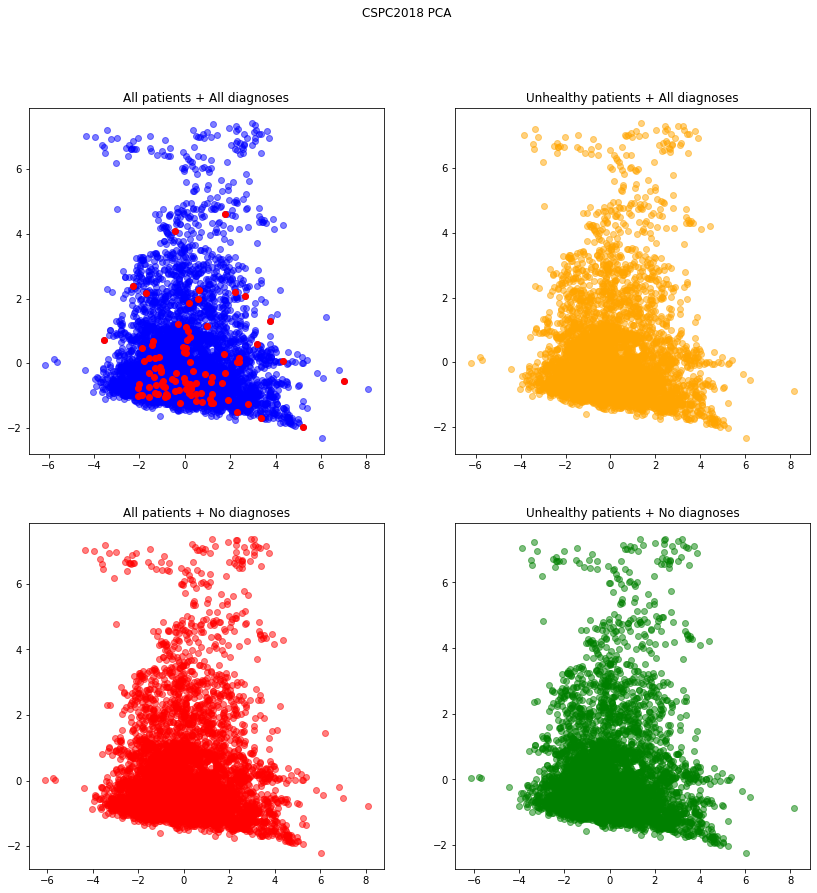

In [49]:
plot_pca(cspc2018_pca_std, 'CSPC2018 PCA', cspc_loc_pred)

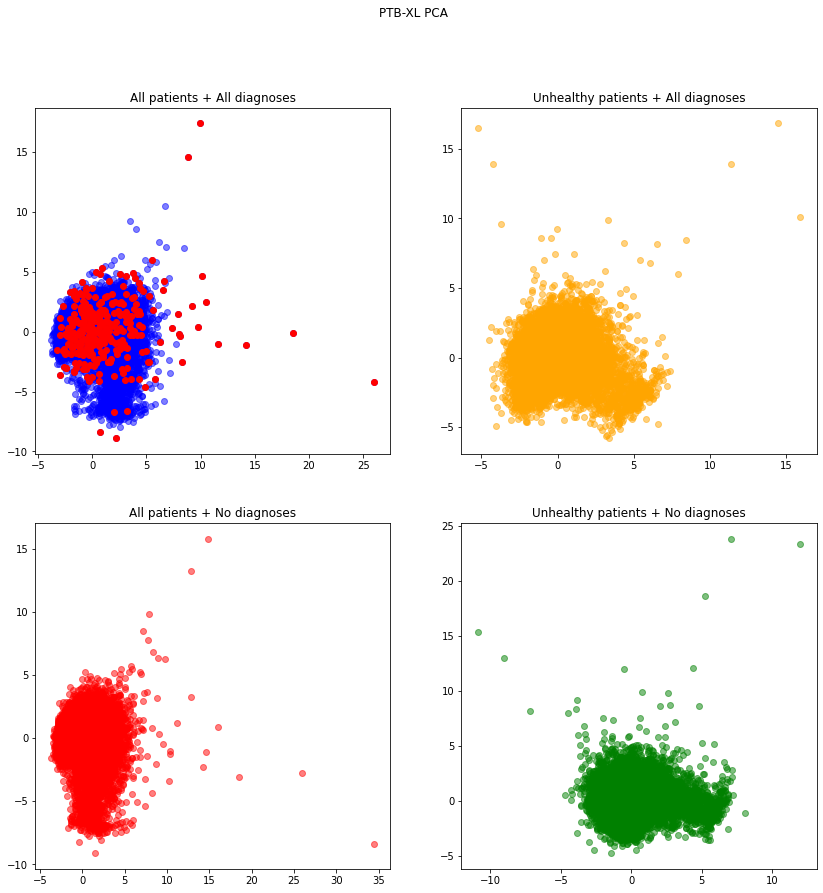

In [50]:
plot_pca(ptb_xl_pca_std, 'PTB-XL PCA', ptb_loc_pred)

Красные точки на фоне синих - это точки, которые алгоритм LocalOutlierFactor пометил как выбросы. Можно заметить, что в случае с PTB-XL многие из помеченных точек действительно находятся далеко от общего скопления (своего рода "хвосты").

Теперь можно строить эластичные графы. В качестве типа графа выберем дерево - оно позволит наиболее наглядно показать, по каким траекториям могут развиваться различные типы аритмии.

Построим эластичные деревья, кол-во вершин возьмем равным 50 (стольки должно быть достаточно, чтобы охватить все возможные траектории).

In [51]:
import elpigraph
from elpigraph import computeElasticPrincipalTree

nnodes = 50


def create_extended_tree(X, nnodes):
    tree_elpi = computeElasticPrincipalTree(X, nnodes, alpha=0.01, Mu=0.1, Lambda=0.05, FinalEnergy='Penalized', n_cores=-1)[0]
    prune_the_tree(tree_elpi)
    tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode="QuantDists", ControlPar=.5, DoSA=False)
    return tree_extended

# cspc2018_tree_norm = [create_extended_tree(X, 50) for X in cspc2018_pca_norm]
# ptb_xl_tree_norm = [create_extended_tree(X, 50) for X in ptb_xl_pca_norm]

cspc2018_tree_std = [create_extended_tree(X, 50) for X in cspc2018_pca_std]
ptb_xl_tree_std = [create_extended_tree(X, 50) for X in ptb_xl_pca_std]

Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
8 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  6877  points and  8  dimensions
Nodes =  2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

2|7||50	5.5156	50	49	28	7	0	0	4.597	4.5843	0.6163	0.6174	0.9078	0.0109	0.5428	27.1423	0


33.9691  seconds elapsed
Removed 4 vertices and 4 edges
Generating the initial configuration
Creating a chain in the 1st PC with 2 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / S

Сохраним получившиеся деревья в формате pkl.

In [52]:
# save_obj(cspc2018_tree_norm, "cspc2018_tree_norm")
# save_obj(ptb_xl_tree_norm, "ptb_xl_tree_norm")

save_obj(cspc2018_tree_std, "cspc2018_tree_std")
save_obj(ptb_xl_tree_std, "ptb_xl_tree_std")

In [53]:
# cspc2018_tree_norm = load_obj("cspc2018_tree_norm")
# ptb_xl_tree_norm = load_obj("ptb_xl_tree_norm")

cspc2018_tree_std = load_obj("cspc2018_tree_std")
ptb_xl_tree_std = load_obj("ptb_xl_tree_std")

Восстановим диагнозы для получившихся датасетов (их можно получить из исходных данных). Они понадобятся для визуализации.

In [54]:
def de_encode_cspc(dataset):
    columns = {'Normal': 0, 'AF': 1, 'I-AVB': 2, 'LBBB': 3, 'PAC': 4, 'PVC': 5, 'RBBB': 6, 'STD': 7, 'STE': 8}
    classes = []

    for i in range(len(dataset)):
        for col in columns:
            try:
                if (dataset.at[i, col]):
                    classes.append(columns[col])
            except KeyError:
                pass

    f_label = pd.Series(classes, name='f_label')
    return dataset.join(f_label)


cspc2018_classes = de_encode_cspc(cspc2018_out)
cspc2018_unhealthy_classes = de_encode_cspc(cspc2018_unhealthy)

In [55]:
cspc2018_orig = [dataset.fillna(dataset.median()) for dataset in cspc2018_datasets]

cspc2018_orig[0]['f_label'] = cspc2018_classes['f_label']
cspc2018_orig[1]['f_label'] = cspc2018_unhealthy_classes['f_label']
cspc2018_orig[2]['f_label'] = cspc2018_classes['f_label']
cspc2018_orig[3]['f_label'] = cspc2018_unhealthy_classes['f_label']
cspc2018_variable_names = [[str(s) for s in data.columns[:]] for data in cspc2018_orig]
cspc2018_orig = [data.to_numpy() for data in cspc2018_orig]

In [56]:
def de_encode_ptb_xl(dataset):
    columns = {'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4, 'MULTIPLE NORM': 6, 'PAIRED': 7, 'MUlTIPLE': 8}
    classes = []

    for i in range(len(dataset)):
        is_norm = False
        counter = 0
        last_col = ''
        for col in columns:
            try:
                if (dataset.at[i, col]):
                    counter += 1
                    last_col = col
                    if col == 'NORM':
                        is_norm = True
            except KeyError:
                pass

        if counter == 1:
            classes.append(columns[last_col])
        elif (counter > 1) and is_norm:
            classes.append(columns['MULTIPLE NORM'])
        elif counter == 2:
            classes.append(columns['PAIRED'])
        elif counter > 2:
            classes.append(columns['MUlTIPLE'])
        else:
            print(f"Last col: {last_col}, Counter: {counter}, Is NORM: {is_norm}")
            raise ValueError('No specific case')

    classes = pd.Series(classes, name='CLASS')
    return dataset.join(classes)

In [57]:
ptb_xl_classes = de_encode_ptb_xl(ptb_xl_out)
ptb_xl_unhealthy_classes = de_encode_ptb_xl(ptb_xl_unhealthy)

In [58]:
ptb_xl_raw_no_ecg = ptb_xl_out.drop(['NORM', 'MI', 'STTC', 'CD', 'HYP'], axis=1)
ixs_duplicates_r = ptb_xl_raw_no_ecg.loc[ptb_xl_raw_no_ecg.duplicated(), :].index
ptb_xl_raw_classes = de_encode_ptb_xl(ptb_xl.drop(ixs_duplicates_r).reset_index(drop=True))

In [59]:
ptb_xl_raw_unhealthy_no_ecg = ptb_xl_unhealthy.drop(['NORM', 'MI', 'STTC', 'CD', 'HYP'], axis=1)
ixs_duplicates_r_u = ptb_xl_raw_unhealthy_no_ecg.loc[ptb_xl_raw_unhealthy_no_ecg.duplicated(), :].index
ptb_xl_raw_unhealthy_classes = de_encode_ptb_xl(ptb_xl_unhealthy.drop(ixs_duplicates_r_u).reset_index(drop=True))

In [60]:
ptb_xl_orig = [dataset.fillna(dataset.median()) for dataset in ptb_xl_datasets]

ptb_xl_orig[0]['CLASS'] = ptb_xl_classes['CLASS']
ptb_xl_orig[1]['CLASS'] = ptb_xl_unhealthy_classes['CLASS']
ptb_xl_orig[2]['CLASS'] = ptb_xl_raw_classes['CLASS']
ptb_xl_orig[3]['CLASS'] = ptb_xl_raw_unhealthy_classes['CLASS']
ptb_xl_variable_names = [[str(s) for s in data.columns[:]] for data in ptb_xl_orig]
ptb_xl_orig = [data.to_numpy() for data in ptb_xl_orig]

## 3. Визуализация деревьев

Подготовим необходимые функции для визуализации, и поместим наши данные в удобные для хранения классы.

In [61]:
def tree_visualization(tree_elpi, X, X_orig, components_vec, mean_val, variable_names):
    vec_labels_by_branches = partition_data_by_tree_branches(X, tree_elpi)

    partition, dists = elpigraph.src.core.PartitionData(X=X, NodePositions=tree_elpi['NodePositions'],
                                                        SquaredX=np.sum(X ** 2, axis=1, keepdims=1),
                                                        MaxBlockSize=100000000, TrimmingRadius=np.inf
                                                        )
    partition_by_node = np.zeros(len(partition))
    for i, p in enumerate(partition):
        partition_by_node[i] = p[0]

    visualize_eltree_with_data(tree_elpi, X, X_orig, components_vec, mean_val, 'k', variable_names,
                               Color_by_partitioning=True, visualize_partition=vec_labels_by_branches)

In [62]:
figsize = (18, 12)
data_titles = ['все пациенты, дерево построено с использованием диагнозов.',
               'больные пациенты, дерево построено с использованием диагнозов.',
               'все пациенты, дерево построено без использования диагнозов.',
               'больные пациенты, дерево построено без использования диагнозов.']

In [63]:
class DataForTree:
    def __init__(self, tree_pack, pca_pack, dataset_orig_pack, components_pack,
                 mnval_pack, var_names_pack, title_pack, title):
        self.tree_pack = tree_pack
        self.pca_pack = pca_pack
        self.dataset_orig_pack = dataset_orig_pack
        self.components_pack = components_pack
        self.mnval_pack = mnval_pack
        self.var_names_pack = var_names_pack
        self.title_pack = title_pack
        self.title = title


# data_for_cspc2018_tree_norm = DataForTree(cspc2018_tree_norm, сspc2018_pca_norm, cspc2018_orig,
#                                           сspc2018_components_norm, сspc2018_mnval_norm, cspc2018_variable_names,
#                                           data_titles,
#                                           "CSPC2018. Метод обработки - нормализация.")
#
# data_for_ptb_xl_tree_norm = DataForTree(ptb_xl_tree_norm, ptb_xl_pca_norm, ptb_xl_orig,
#                                         ptb_xl_components_norm, ptb_xl_mnval_norm, ptb_xl_variable_names, data_titles,
#                                         "PTB-XL. Метод обработки - нормализация.")


data_for_cspc2018_tree_std = DataForTree(cspc2018_tree_std, cspc2018_pca_std, cspc2018_orig,
                                         cspc2018_components_std, cspc2018_mnval_std, cspc2018_variable_names,
                                         data_titles,
                                         "CSPC2018.")  # Метод обработки - стандартизация.")

data_for_ptb_xl_tree_std = DataForTree(ptb_xl_tree_std, ptb_xl_pca_std, ptb_xl_orig,
                                       ptb_xl_components_std, ptb_xl_mnval_std, ptb_xl_variable_names, data_titles,
                                       "PTB-XL.")  # Метод обработки - стандартизация.")

### Визуализация атрибутов и исследование деревьев

In [64]:
def plot_trees(data, data_index, main_feature, other_features):
    fig3 = plt.figure(figsize=figsize, constrained_layout=True)

    gs = fig3.add_gridspec(len(other_features), 1 + len(other_features))

    f3_ax1 = fig3.add_subplot(gs[:, :-1])
    visualize_eltree_with_data(data.tree_pack[data_index], data.pca_pack[data_index], data.dataset_orig_pack[data_index],
                               data.components_pack[data_index], data.mnval_pack[data_index], 'k', data.var_names_pack[data_index],
                               Color_by_feature=main_feature, cmap='gist_rainbow', add_color_bar=True,
                               Transparency_Alpha_points=0.5)
    f3_ax1.set_title(main_feature)

    for num_feature in range(len(other_features)):
        f3_ax = fig3.add_subplot(gs[num_feature, -1])
        feature = other_features[num_feature]
        cmap = 'winter' if (feature == 'sex') or (feature == 'SEX') else 'gist_rainbow'
        visualize_eltree_with_data(data.tree_pack[data_index], data.pca_pack[data_index], data.dataset_orig_pack[data_index],
                                   data.components_pack[data_index], data.mnval_pack[data_index], 'k', data.var_names_pack[data_index],
                                   Color_by_feature=feature, cmap=cmap, add_color_bar=True,
                                   Transparency_Alpha_points=0.5)
        f3_ax.set_title(feature)

    fig3.suptitle(f"Диагнозы и другие признаки датасета {data.title} При построении задействованы {data.title_pack[data_index]}", fontsize=16)
    plt.show()

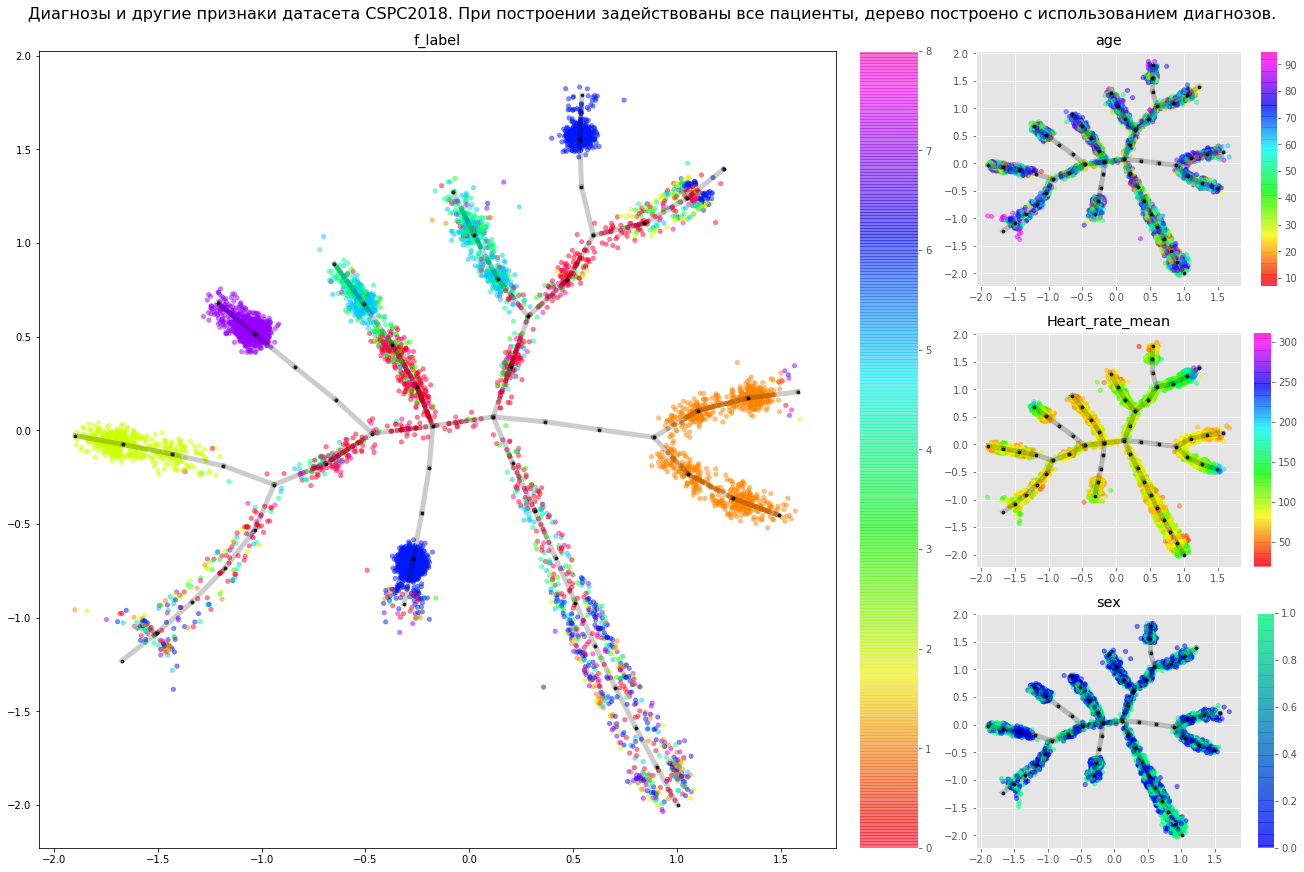

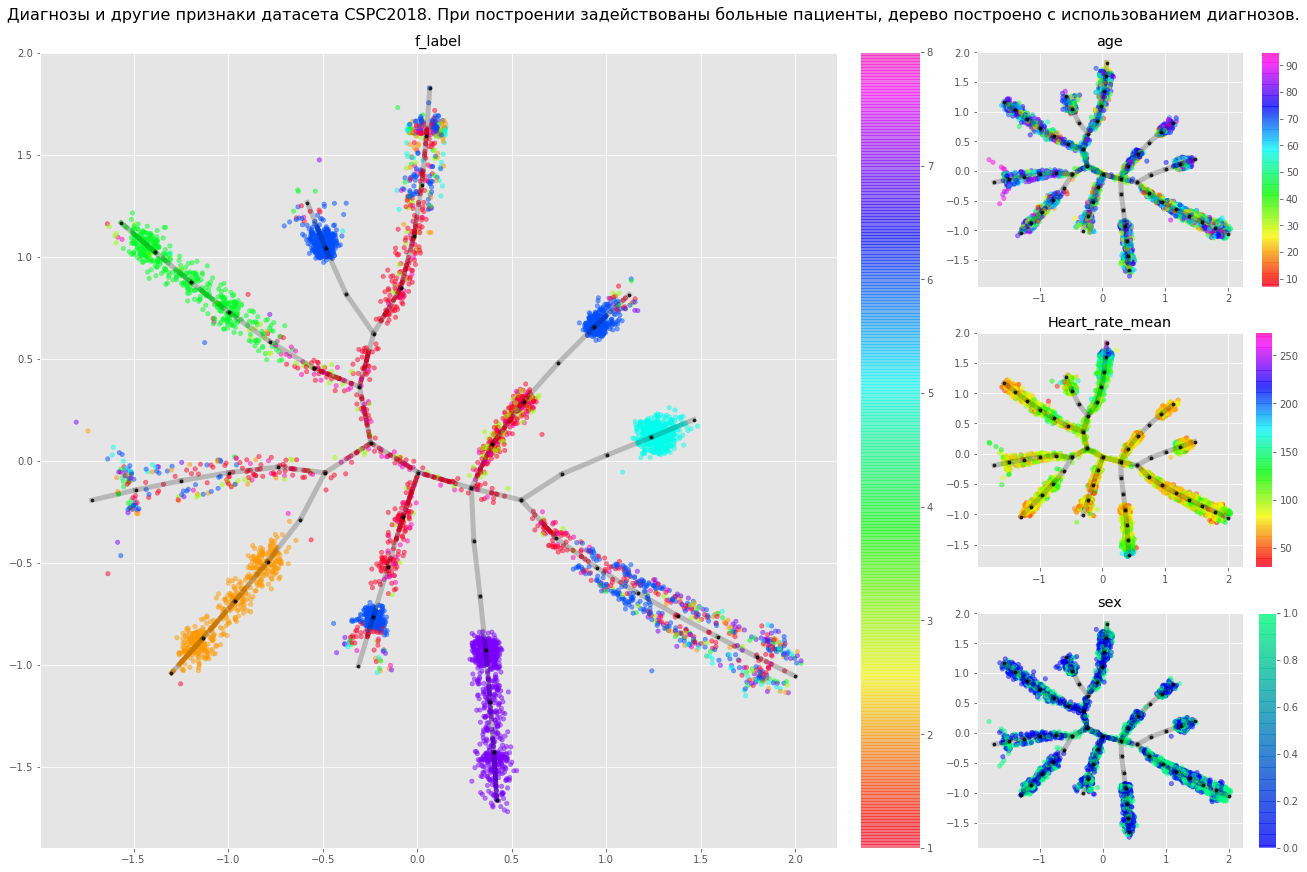

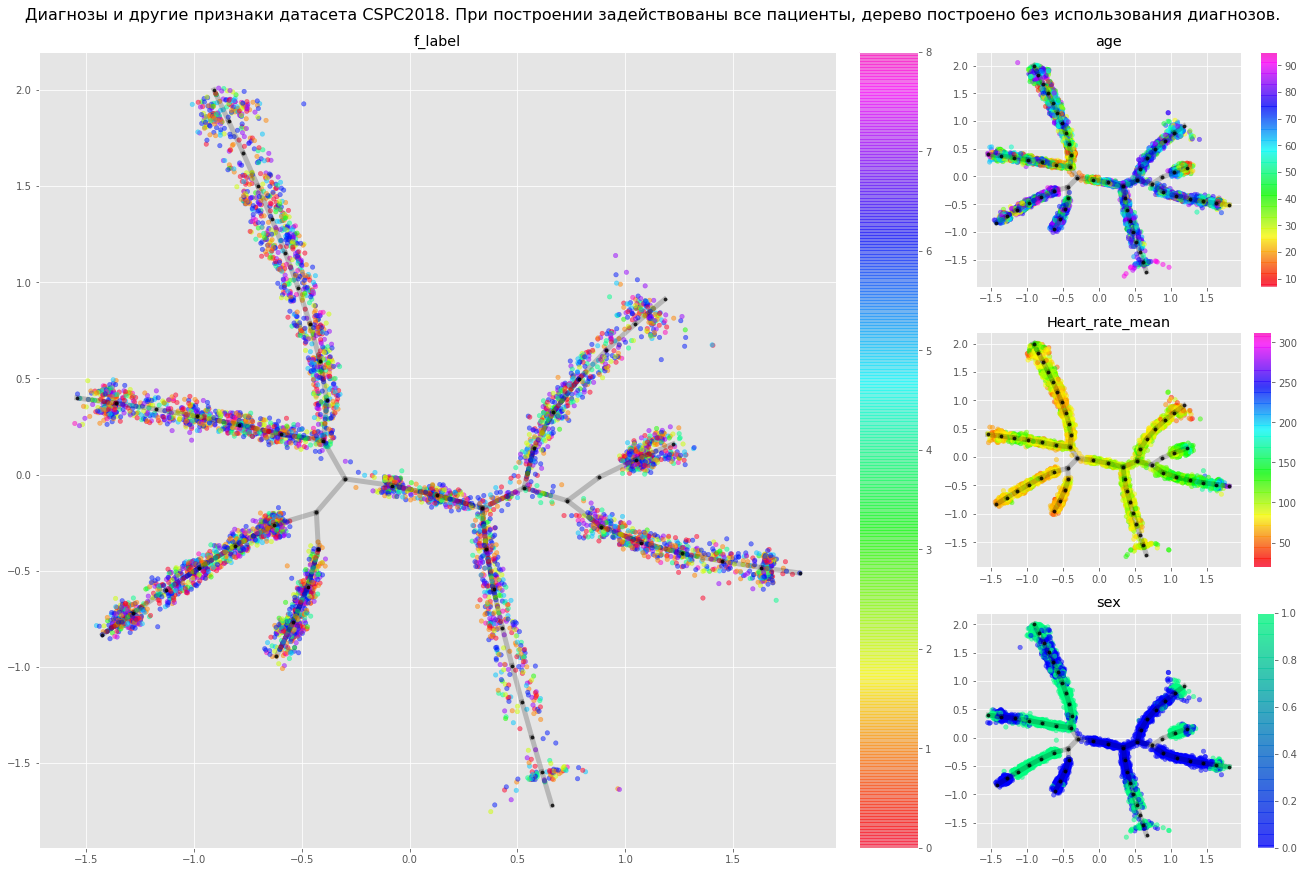

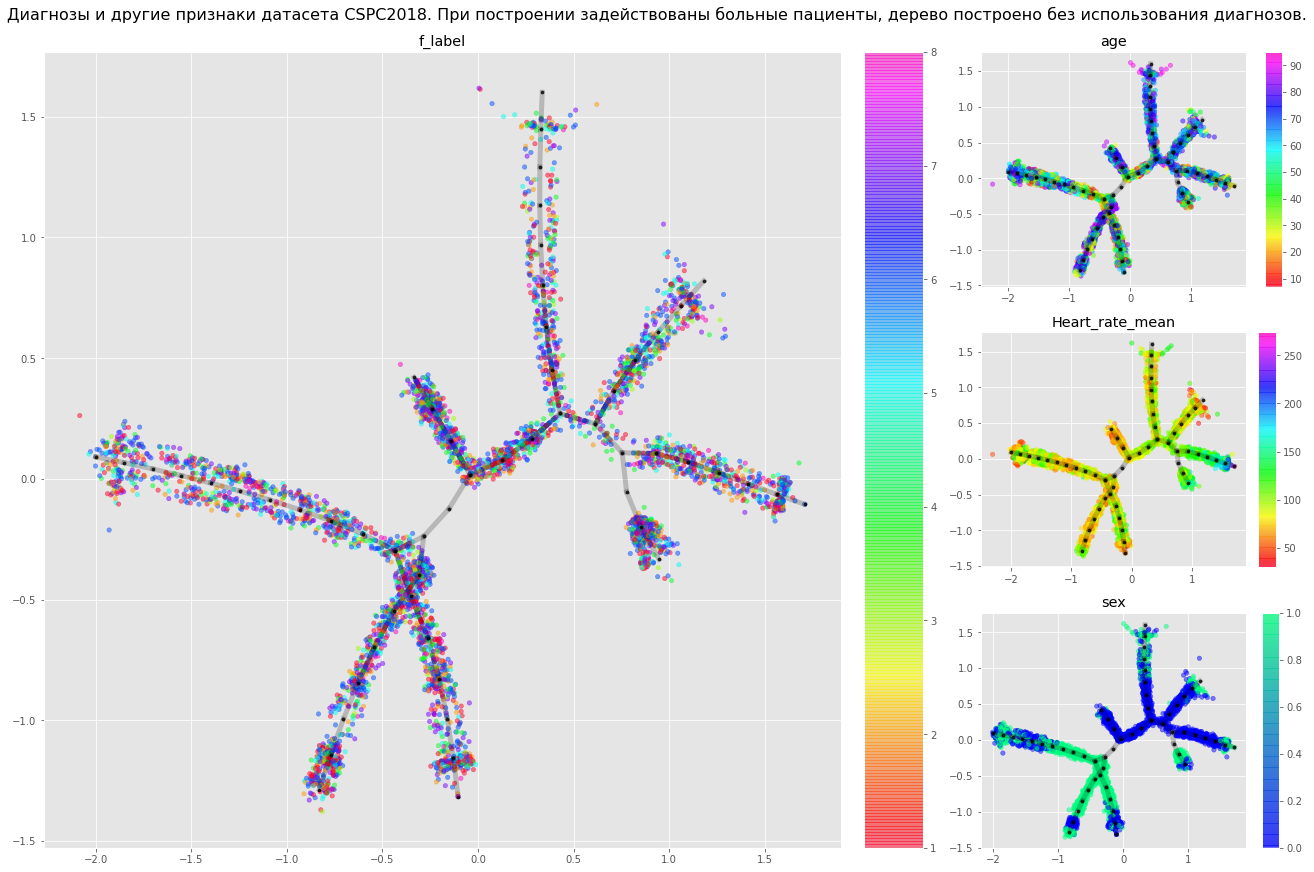

In [65]:
for i in range(4):
    plot_trees(data_for_cspc2018_tree_std, i, 'f_label', ['age', 'Heart_rate_mean', 'sex'])

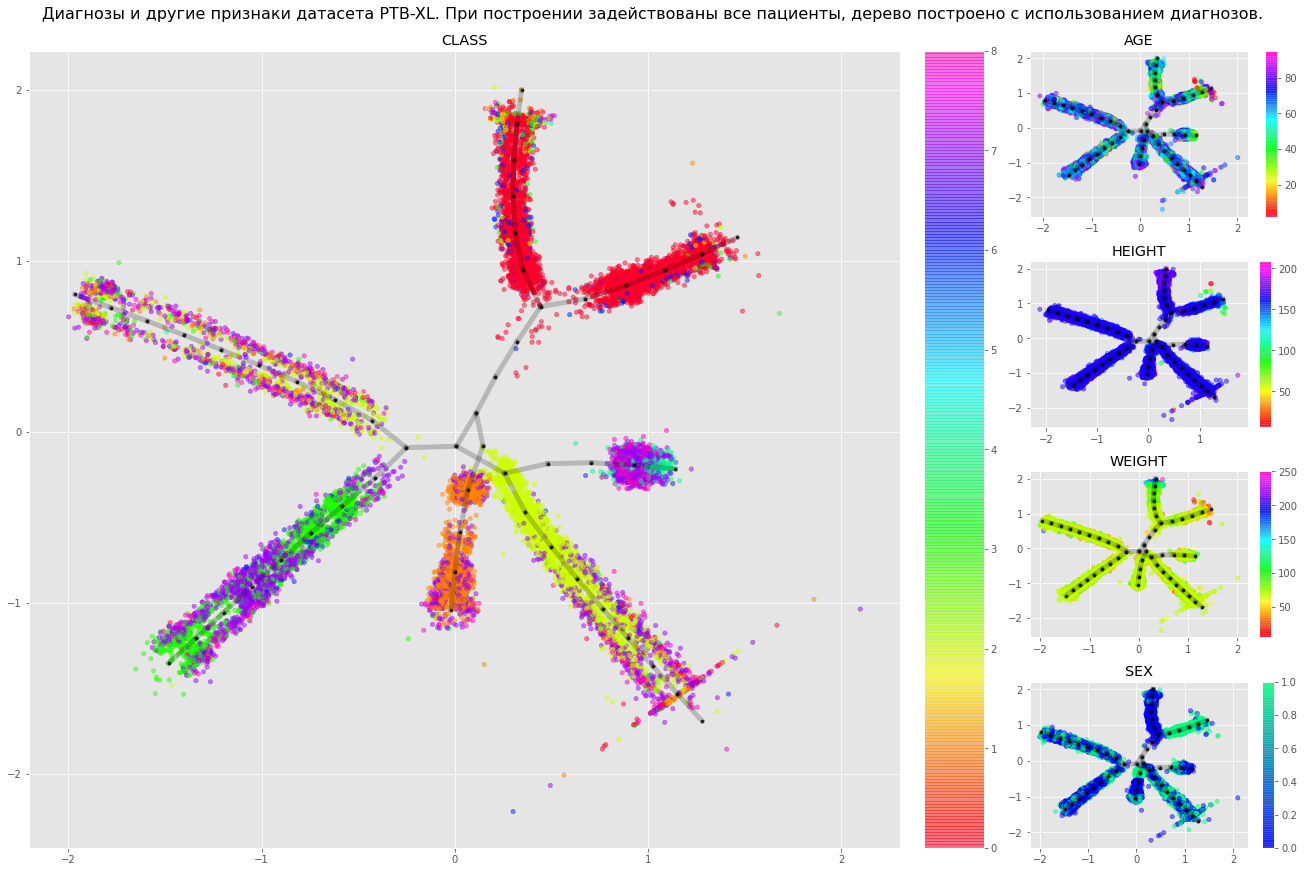

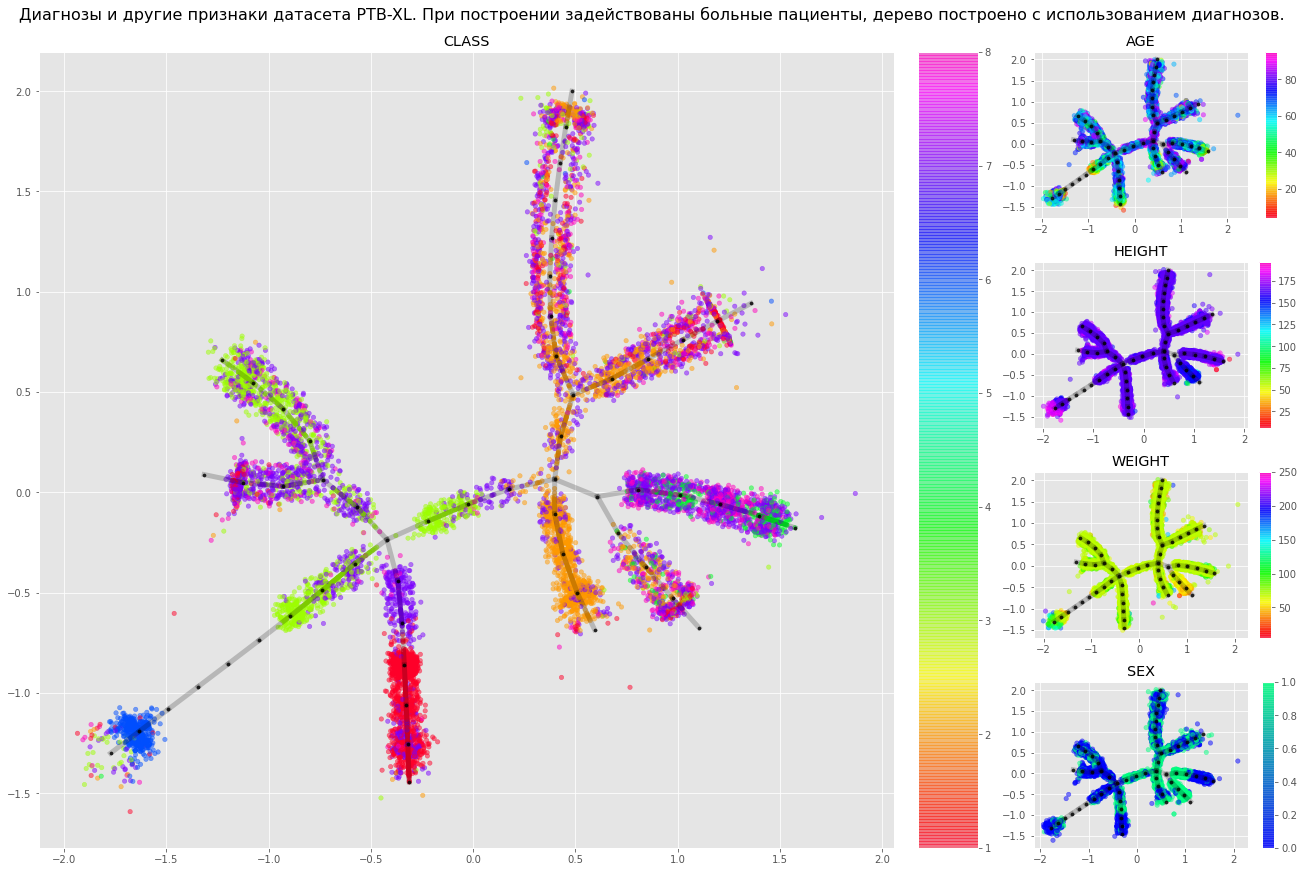

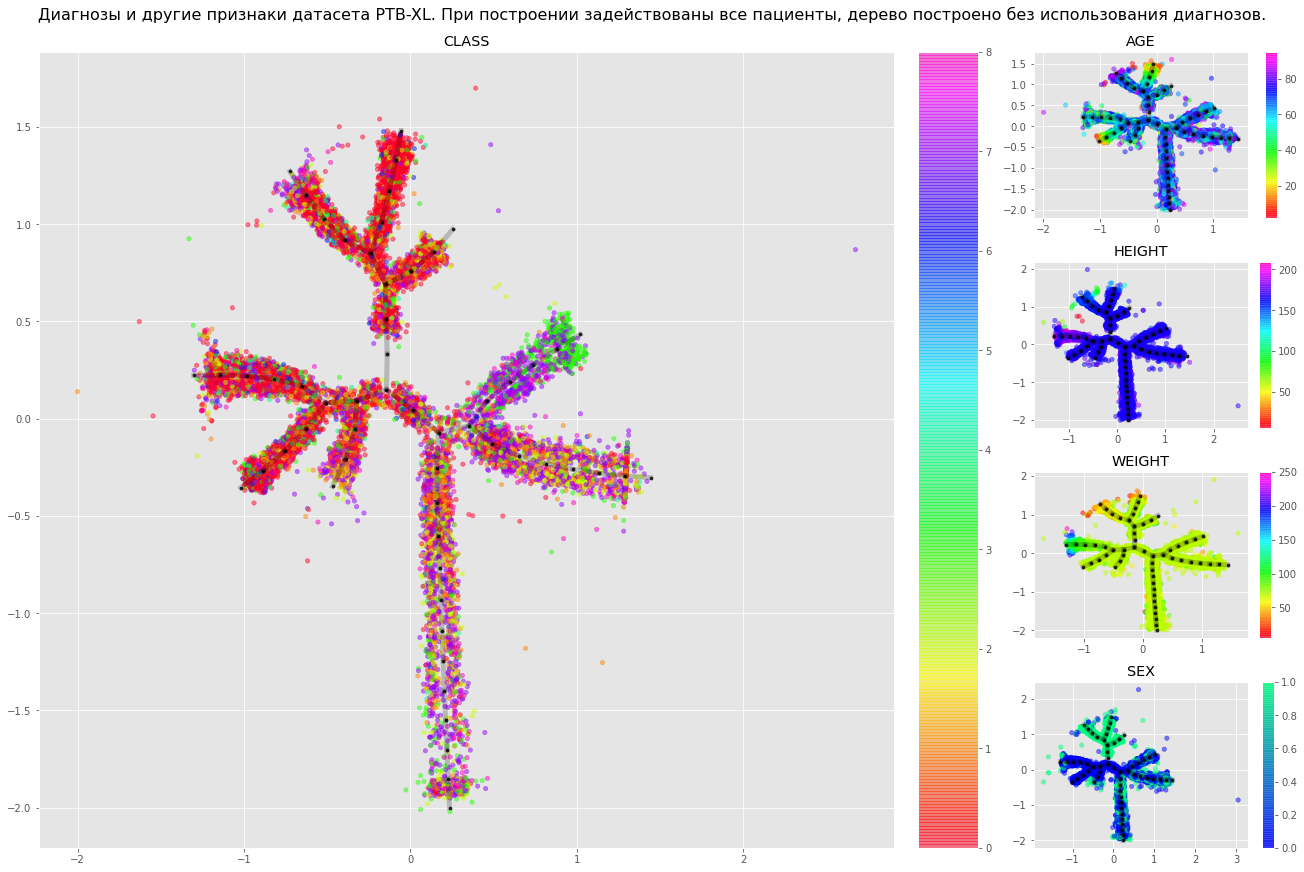

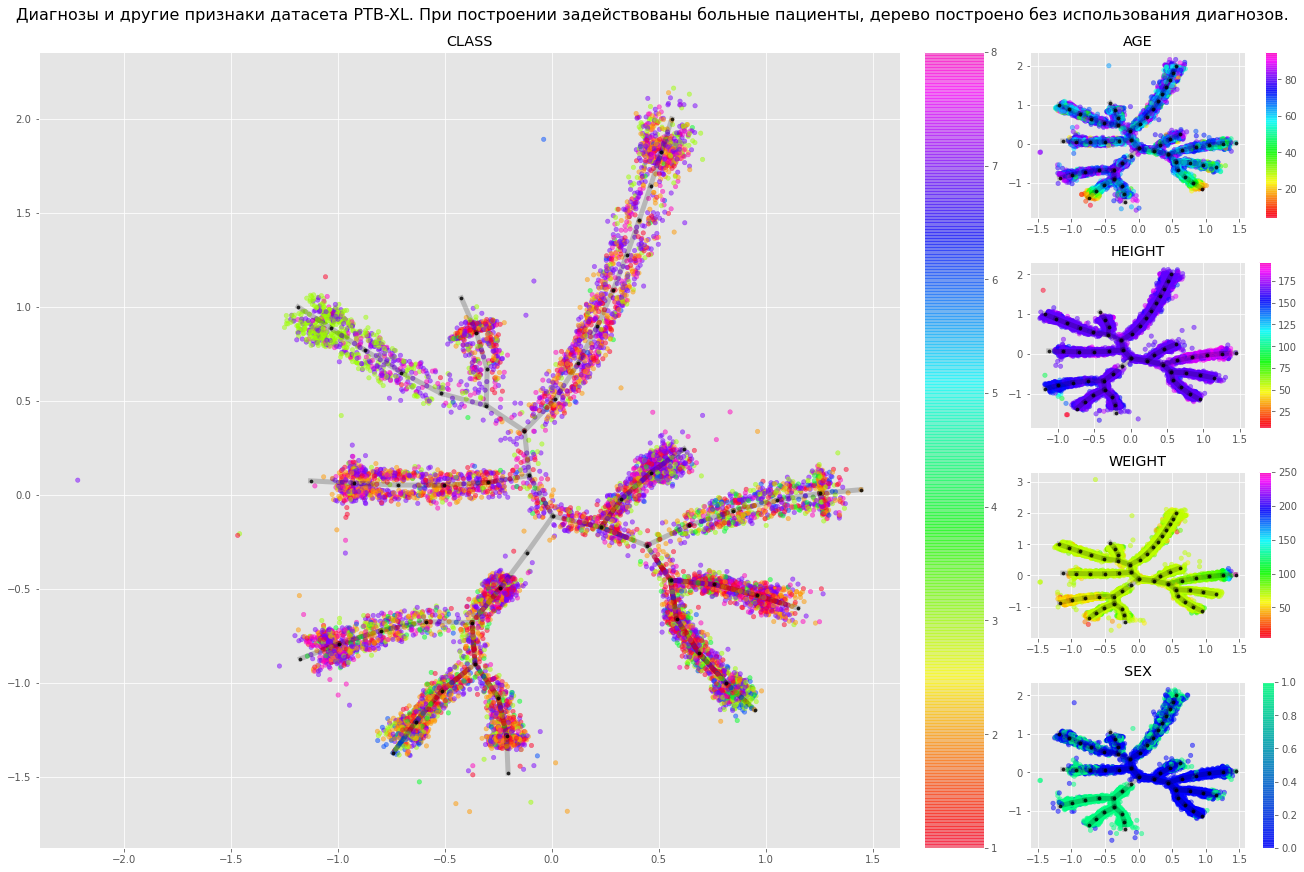

In [66]:
for i in range(4):
    plot_trees(data_for_ptb_xl_tree_std, i, 'CLASS', ['AGE', 'HEIGHT', 'WEIGHT', 'SEX'])

Получились довольно интересные результаты. На некоторых из деревьев действительно можно проследить плавные изменения диагнозов по мере движения по ветке. Особенно это заметно на деревьях, построенных на основе CSPC2018. Однако если дерево строится без использования диагнозов, то оно "настраивается" на другие признаки, и диагнозы в нем оказываются распределены довольно равномерно.

#### Больные пациенты младше 30

Пометим всех пациентов младше 30, у которых есть отклонения от нормы в диагнозе, красным цветом, остальных - черным.

In [67]:
some_age = 30

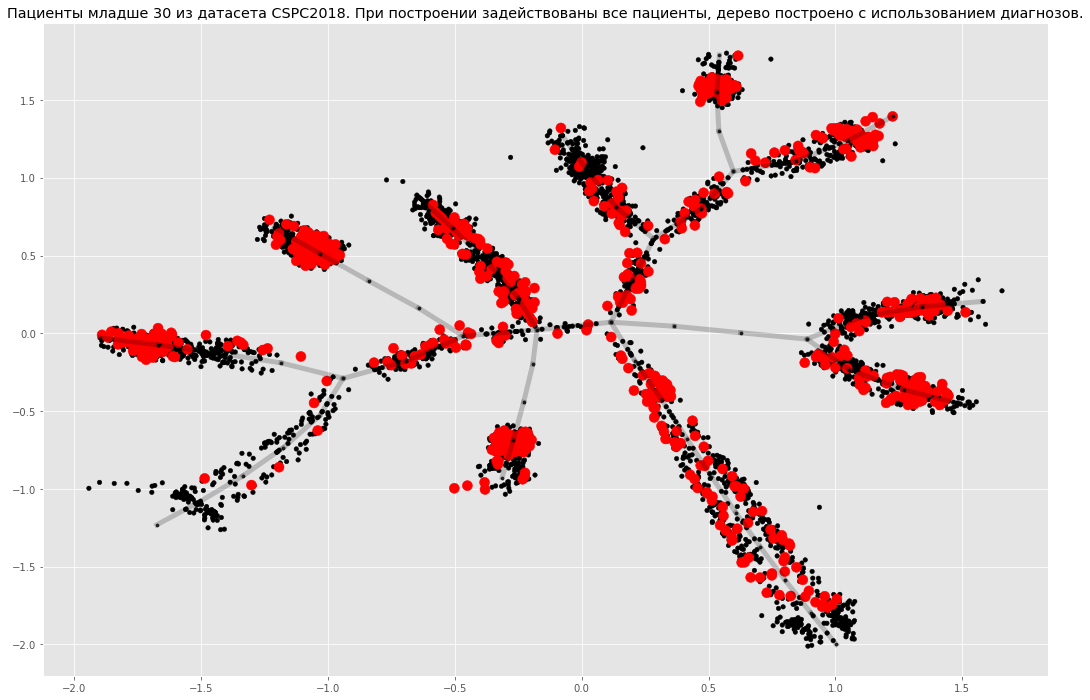

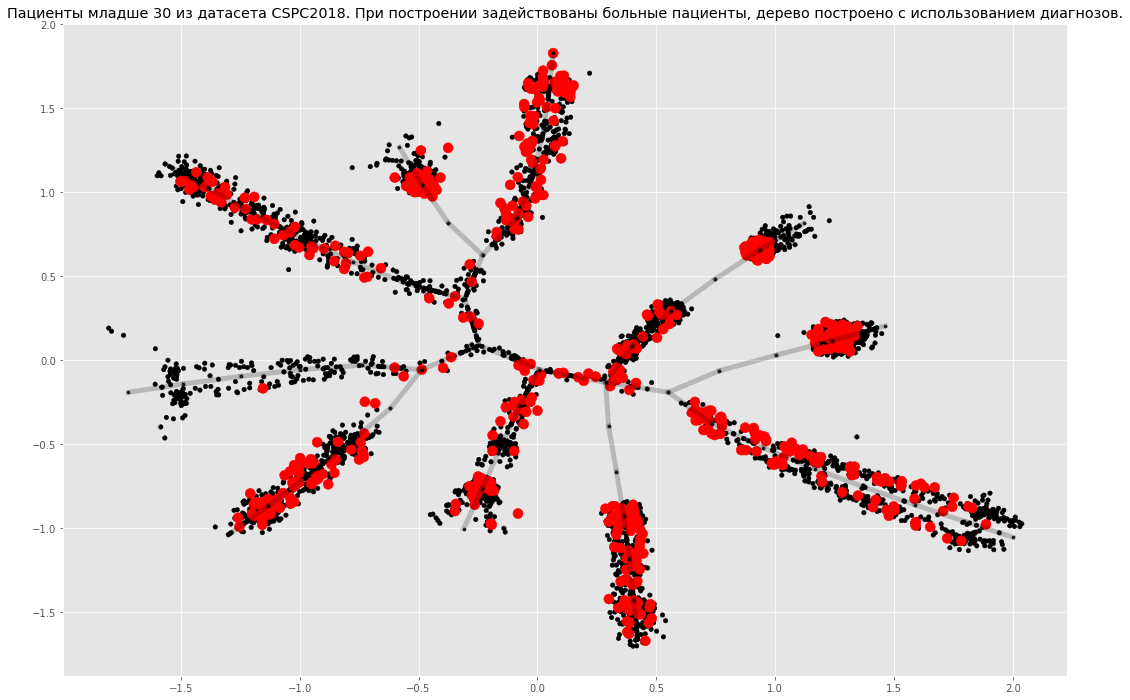

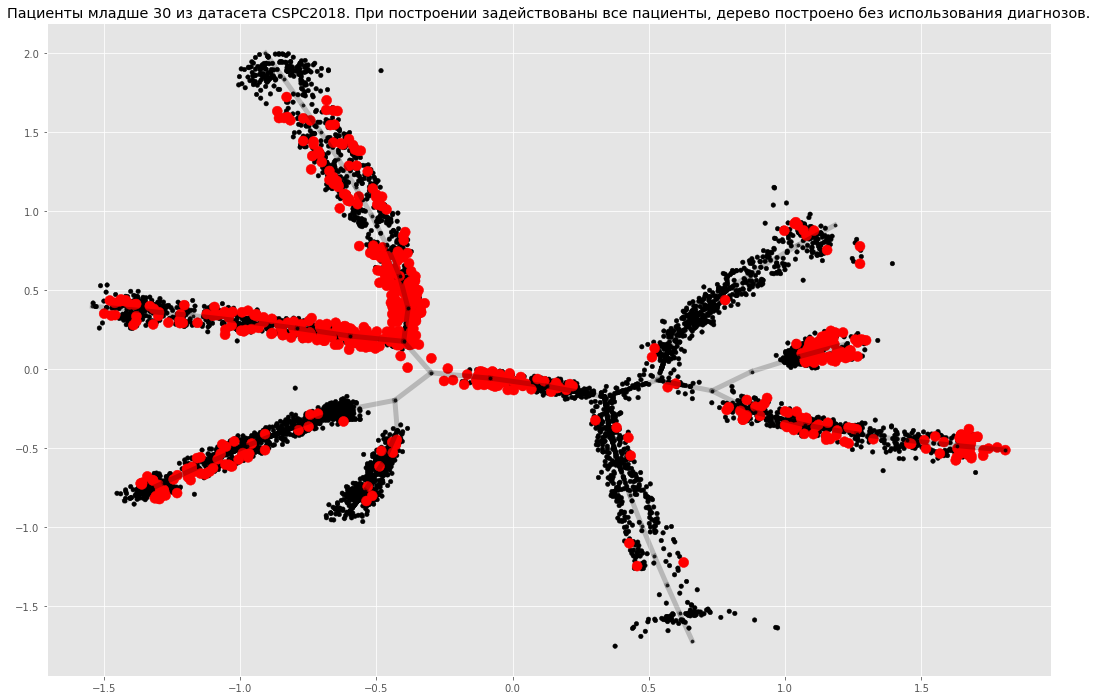

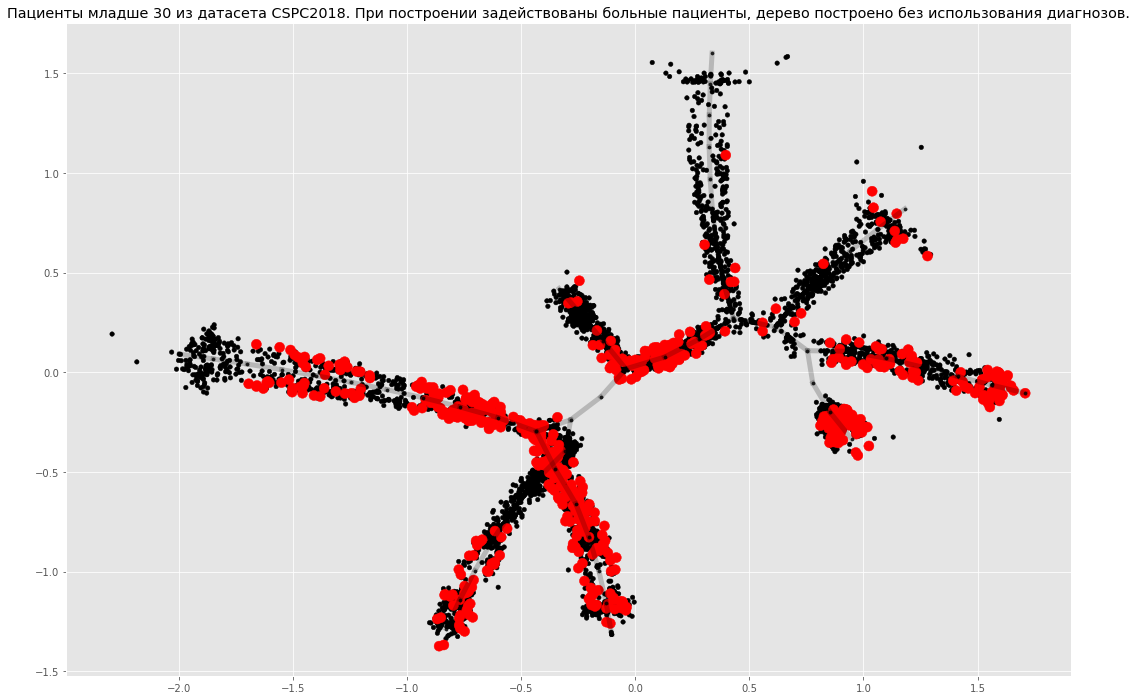

In [68]:
for i in range(4):
    data = data_for_cspc2018_tree_std

    fig = plt.figure(figsize=figsize)
    inds = np.where((data.dataset_orig_pack[i][:, data.var_names_pack[i].index('age')] <= some_age) &
                    (data.dataset_orig_pack[i][:, data.var_names_pack[i].index('f_label')] >= 0))[0]
    colors = ['k' for j in range(len(data.pca_pack[i]))]
    for j in inds:
        colors[j] = 'r'
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i],
                               data.components_pack[i], data.mnval_pack[i], colors, data.var_names_pack[i],
                               highlight_subset=inds, cmap='hot')
    plt.title(f"Пациенты младше {some_age} из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()

    print("\n\n")

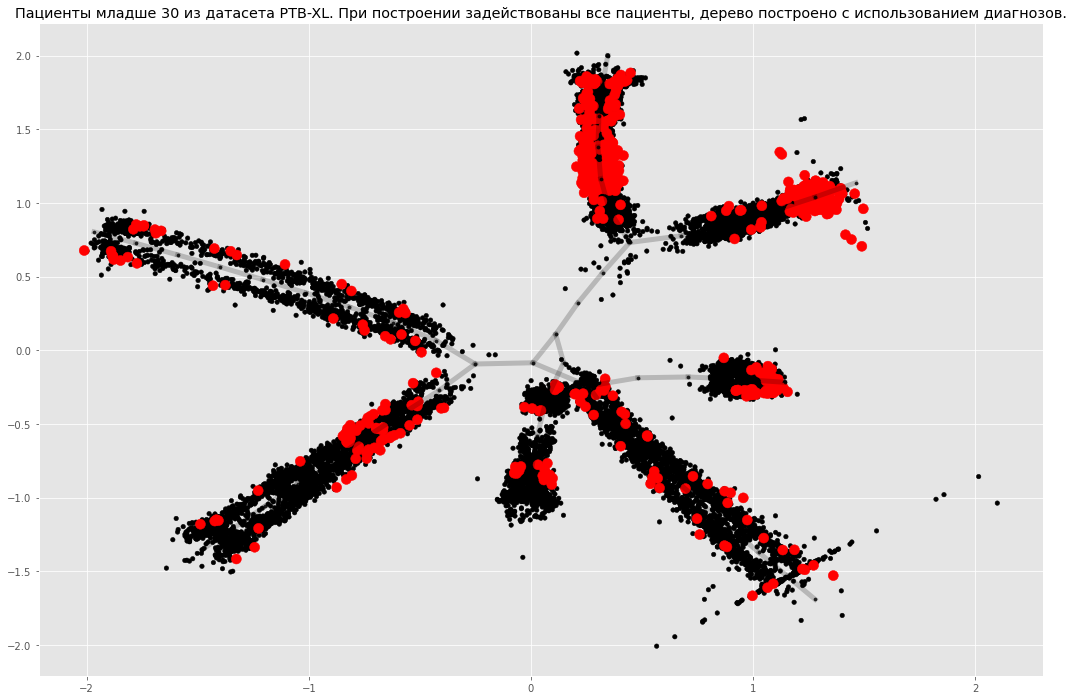

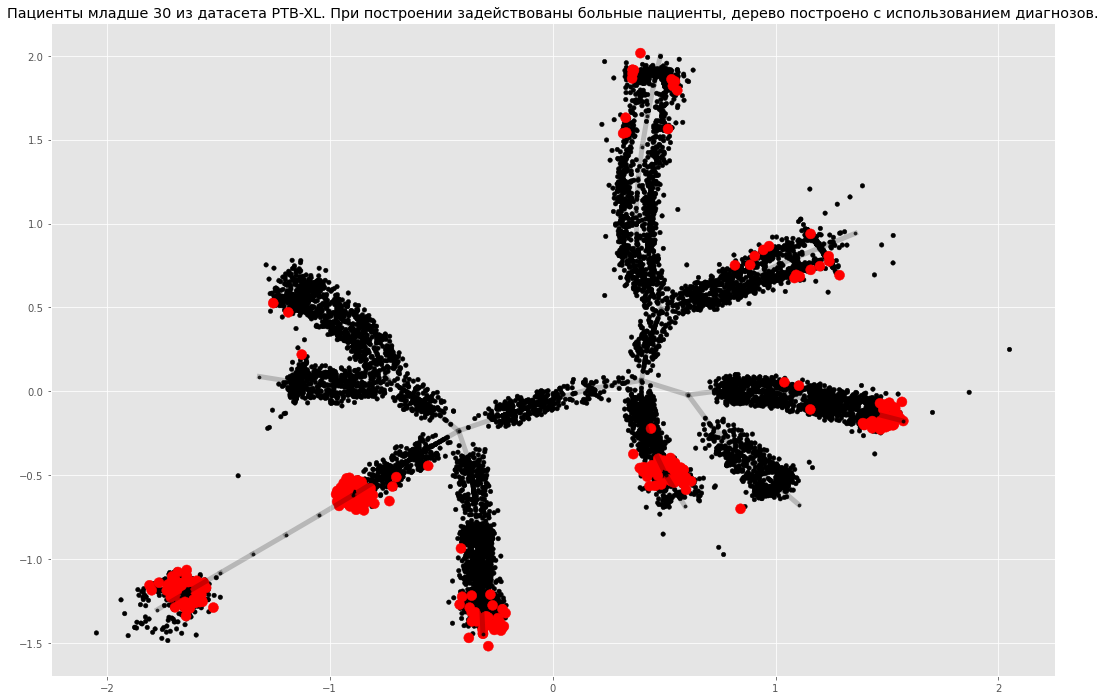

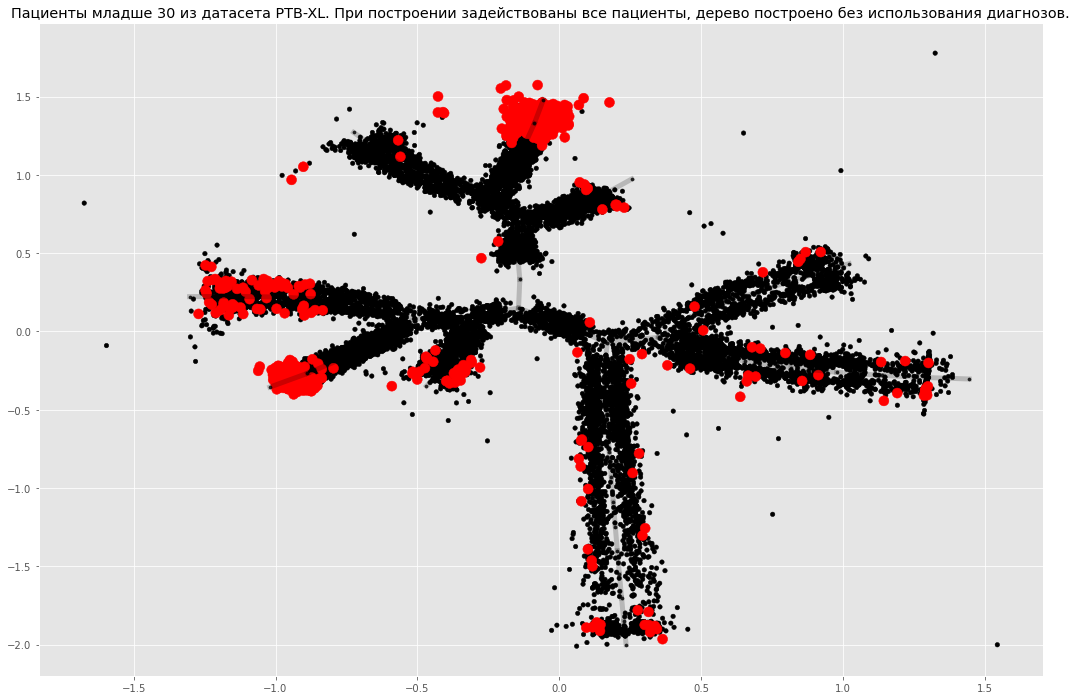

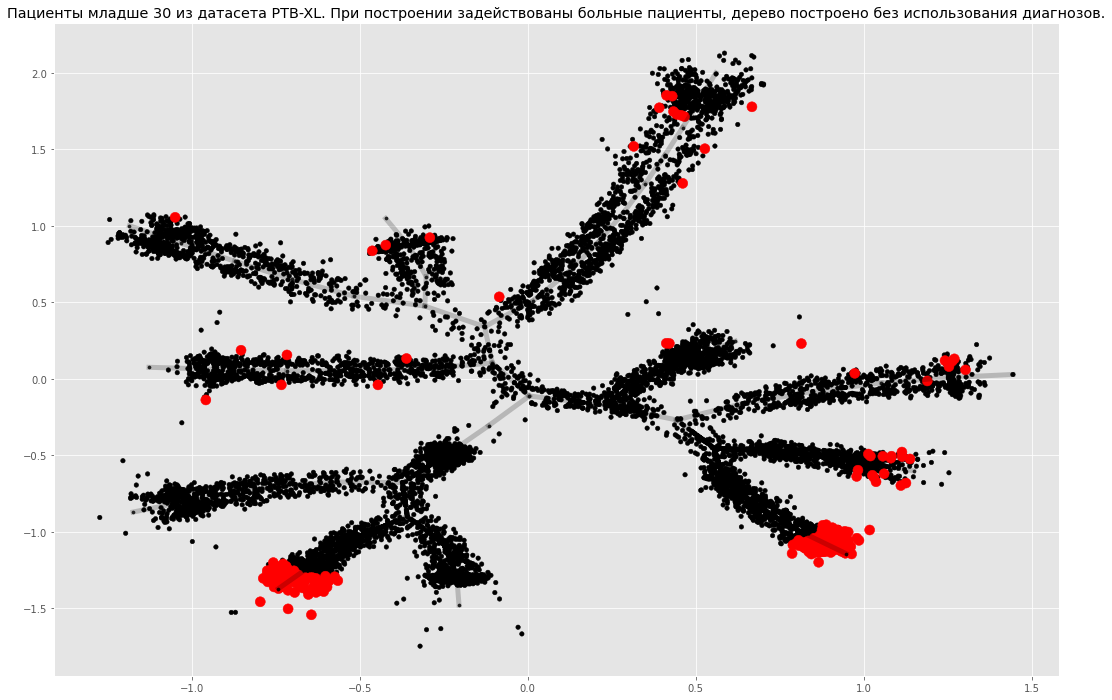

In [69]:
for i in range(4):
    data = data_for_ptb_xl_tree_std

    fig = plt.figure(figsize=figsize)
    inds = np.where((data.dataset_orig_pack[i][:, data.var_names_pack[i].index('AGE')] <= some_age) &
                    (data.dataset_orig_pack[i][:, data.var_names_pack[i].index('CLASS')] >= 0))[0]
    colors = ['k' for j in range(len(data.pca_pack[i]))]
    for j in inds:
        colors[j] = 'r'
    visualize_eltree_with_data(data.tree_pack[i], data.pca_pack[i], data.dataset_orig_pack[i],
                               data.components_pack[i], data.mnval_pack[i], colors, data.var_names_pack[i],
                               highlight_subset=inds, cmap='hot')
    plt.title(f"Пациенты младше {some_age} из датасета {data.title} При построении задействованы {data.title_pack[i]}")
    plt.show()

    print("\n\n")

# Заключение

В ходе данной работы были обработаны полученные из первой части работы датасеты. На их основе были построены эластичные графы (деревья): по 4 на каждый из двух датасетов. Визуализация показала, что полученные графы можно анализировать и делать выводы относительно протекания аритмии у различных людей. Однако результаты все еще экспериментальные, и следует провести больше исследований (а также консультаций со специалистами), чтобы интерпретация результатов была более содержательной.

При проведении дальнейших исследований требуется:
1. Построить отдельную визуализацию столбцов-диагнозов,
2. Проанализировать детальнее выбросы и графики первых признаков PCA,
3. Провести тюнинг параметров построения дерева (к примеру, настроить alpha - ветвистость дерева),
4. Попробовать сначала построить дерево, а потом применить к нему PCA,
5. При успешных результатах проверить возможность смоделировать траектории внутри деревьев и движение по ним в течение некоторого псевдовремени.